# Data Processing

** After exploration, we have already known:**
* Large quantity of missing value in each feature
* Feature Sparsely distributed 
* Target Y nearly normally distributed, but still outliers in each side of the tail

** To address those challenges above:**
* drop features with more than 1/3 missing values
* add dummy features capturing missing value distribution and missing value count
* sort the data and then do forward filling with gap limit of 3
* fill the remaining missing value with median
* add dummy features capturing outliers
* add a feature predicted by isolatedTrees 
* add a feature predicted with imbalanced-classes classification with randomForest 

In [22]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import groupby
from collections import Counter

%matplotlib inline

In [ ]:
with pd.HDFStore("data/train.h5", "r") as train:
    # Note that the "train" dataframe is the only dataframe in the file
    df = train.get("train")
df.shape

In [ ]:
## drop cols with over 30% missing value
missing_ratio = df.isnull().sum()/df.shape[0]
col_to_drop = missing_ratio.where(lambda x:x>0.3).dropna().index
df = df.drop(col_to_drop, axis=1)

In [5]:
## original feature cols
feature_cols = [x for x in list(df.columns) if x not in ['id','timestamp','y']]

In [10]:
## calculate the median for each column before filling missing value
d_median= df.median(axis=0)
n = df.isnull().sum(axis=1)

for c in feature_cols:
    df[c + '_nan_'] = pd.isnull(df[c]) ## add col to indicate if the number is null or not
    d_median[c + '_nan_'] = 0

    
## forward fill the missing value, gap limit set to be three
df_ffilled = df.set_index(['id','timestamp']).sort_index().fillna(method = 'ffill',limit =3).reset_index()

## fill the other missing values with median
df_filled = df_ffilled.fillna(d_median)

## add another col to indicate number of missing values
df_filled['znull'] = n

In [ ]:
## transform values into their reciprocals for more centralized distribution

df_transformed = df_filled.copy()
non_transformable_fea = []

for feature in feature_cols:
    try:
        transformed_list = list(map(lambda x:1/x,df_filled[feature]))
        df_transformed[feature]=transformed_list
    except OverflowError:
        print('%s transformation meet a overflow error'%feature)
        non_transformable_fea.append(feature)
    except ValueError:
        print('%s transformation meet a Value error'%feature)
        non_transformable_fea.append(feature)

C:\Users\Miya\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j
C:\Users\Miya\Anaconda3\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


fundamental_62 transformation meet a overflow error
technical_0 transformation meet a overflow error
technical_2 transformation meet a overflow error
technical_6 transformation meet a overflow error
technical_7 transformation meet a overflow error
technical_9 transformation meet a Value error
technical_10 transformation meet a Value error
technical_11 transformation meet a overflow error
technical_12 transformation meet a overflow error
technical_13 transformation meet a Value error
technical_14 transformation meet a overflow error
technical_16 transformation meet a Value error
technical_17 transformation meet a overflow error
technical_18 transformation meet a Value error
technical_20 transformation meet a Value error
technical_22 transformation meet a Value error
technical_29 transformation meet a overflow error
technical_30 transformation meet a Value error
technical_32 transformation meet a overflow error
technical_34 transformation meet a Value error
technical_37 transformation me

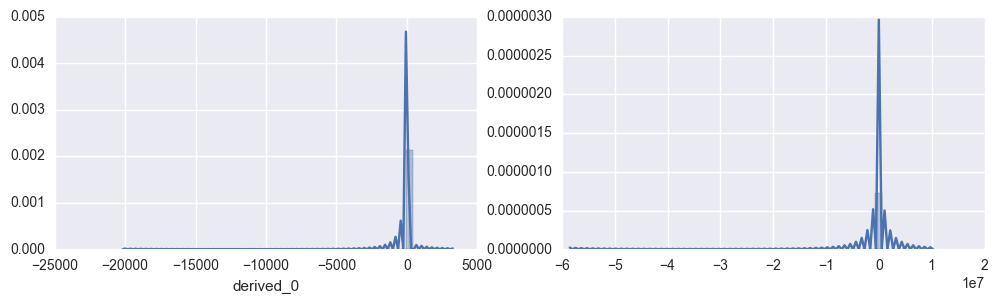

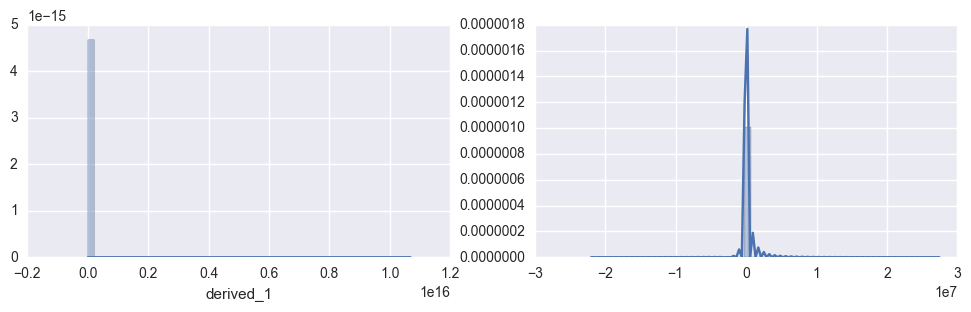

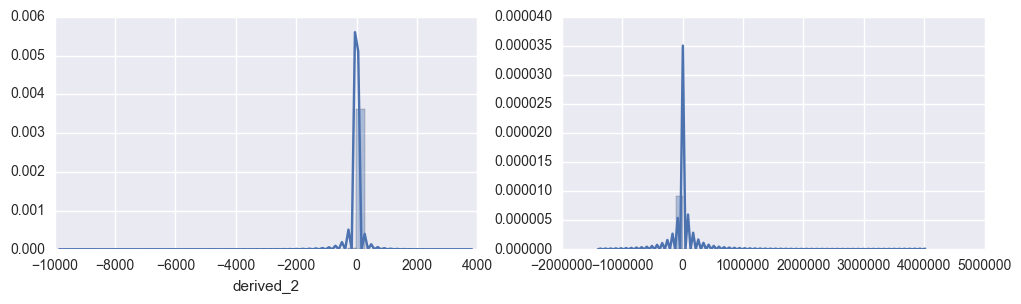

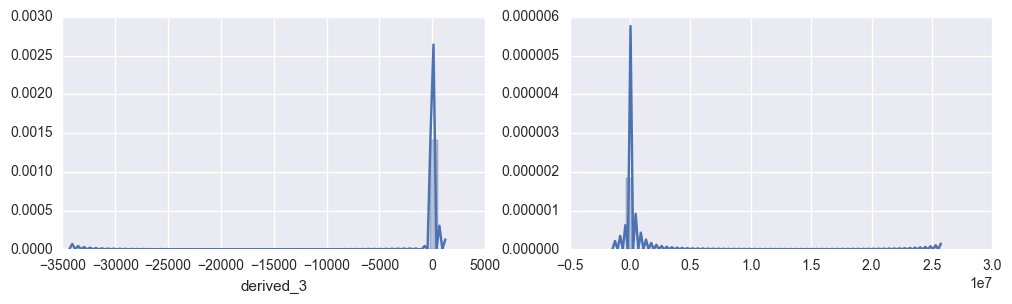

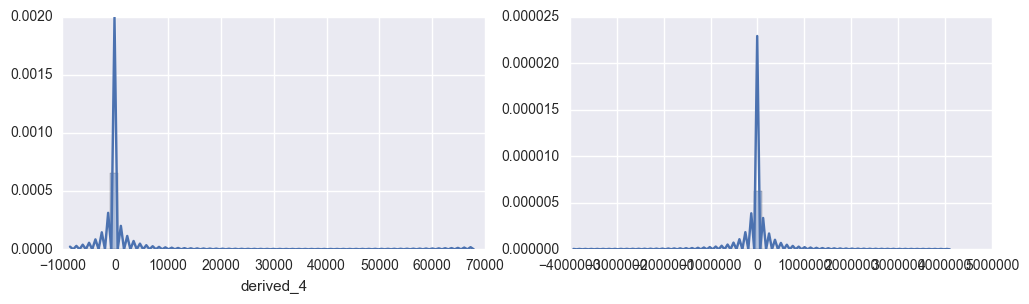

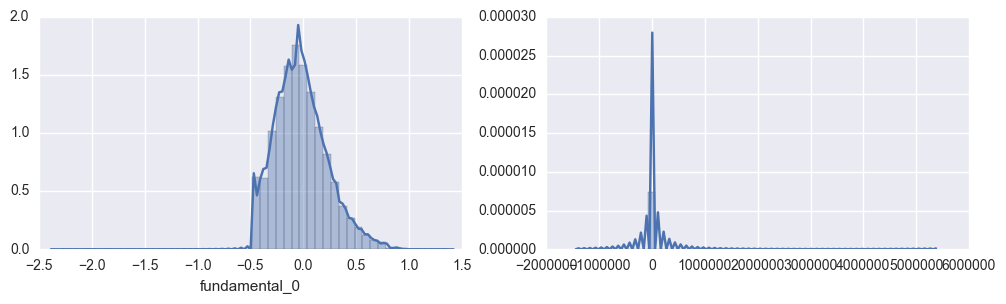

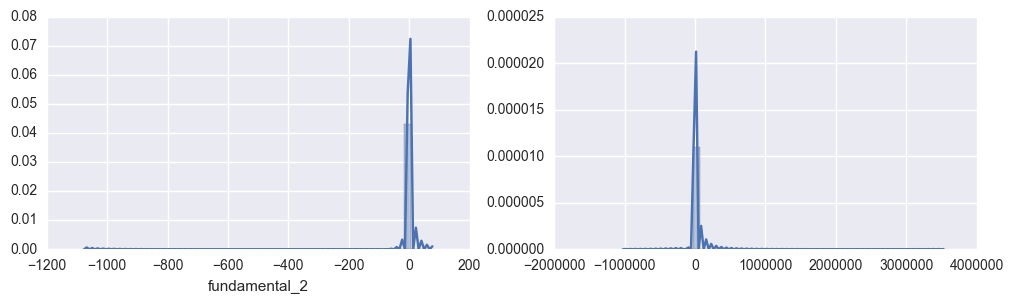

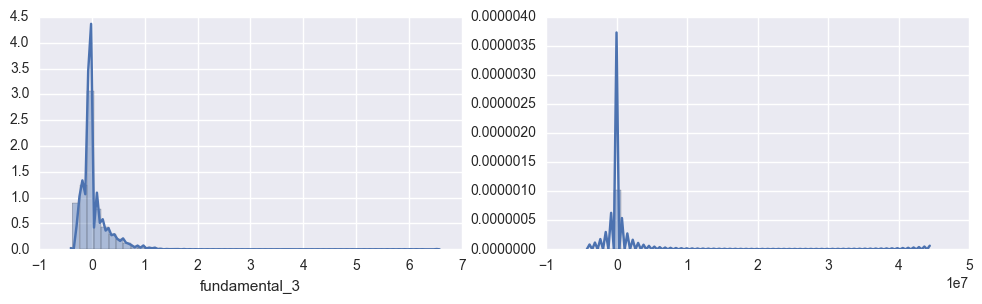

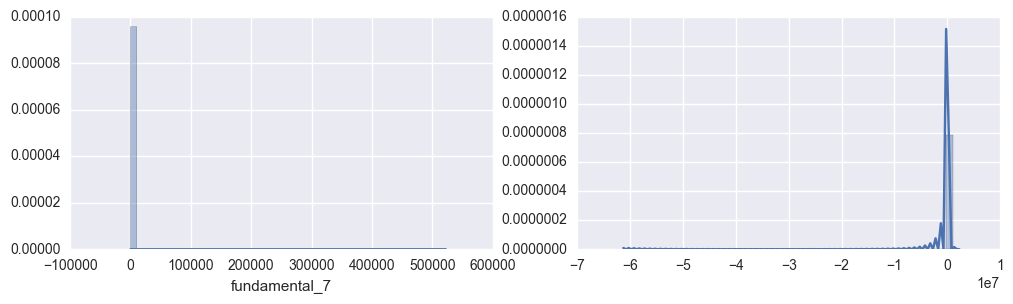

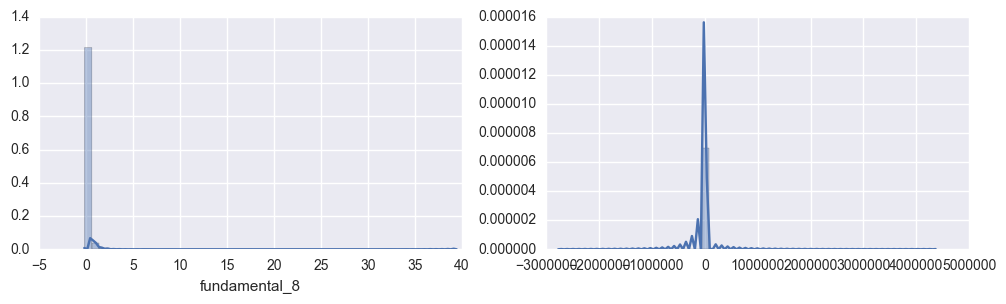

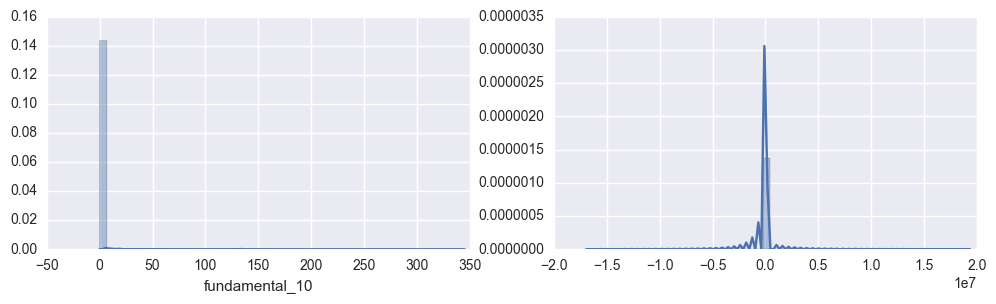

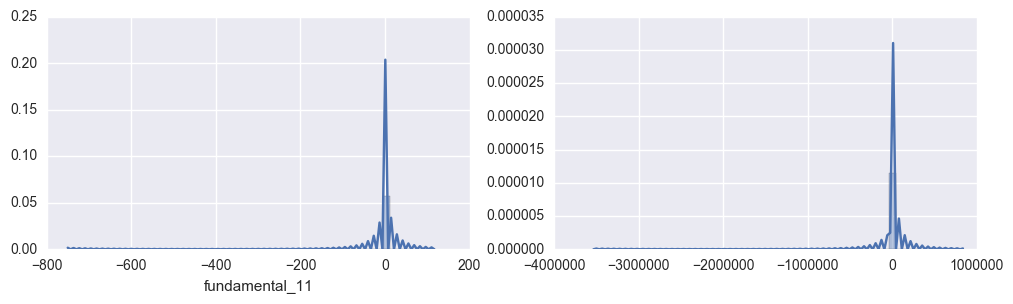

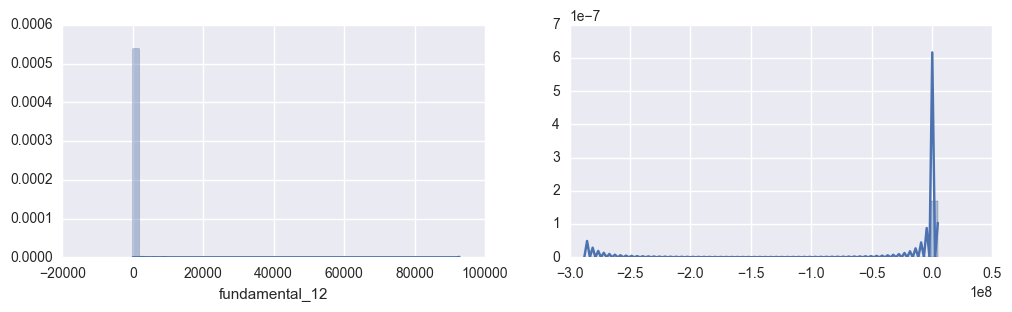

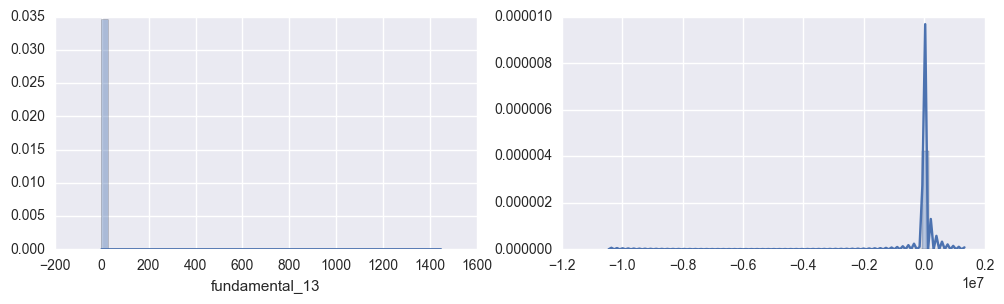

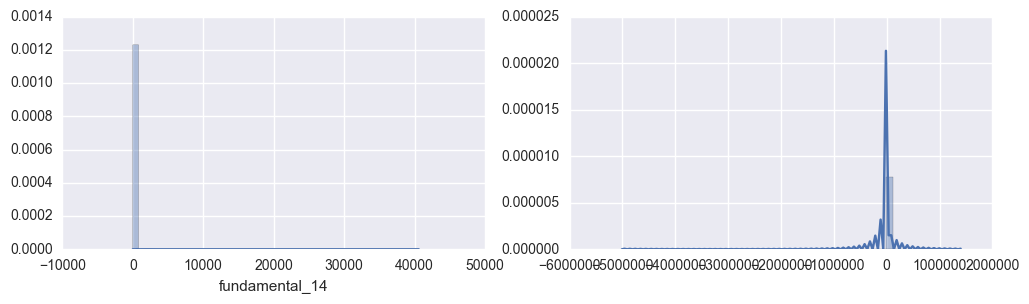

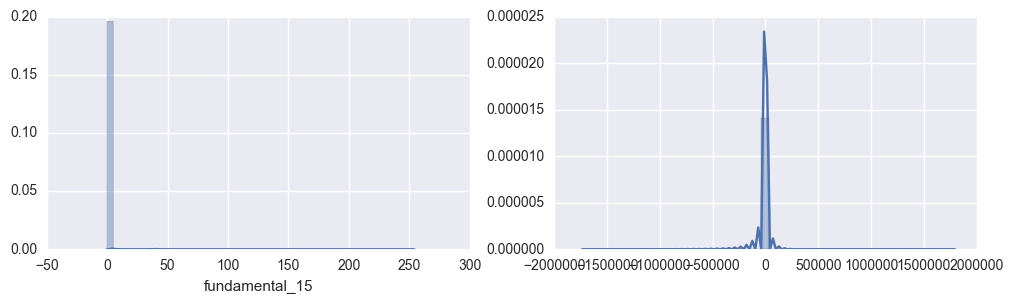

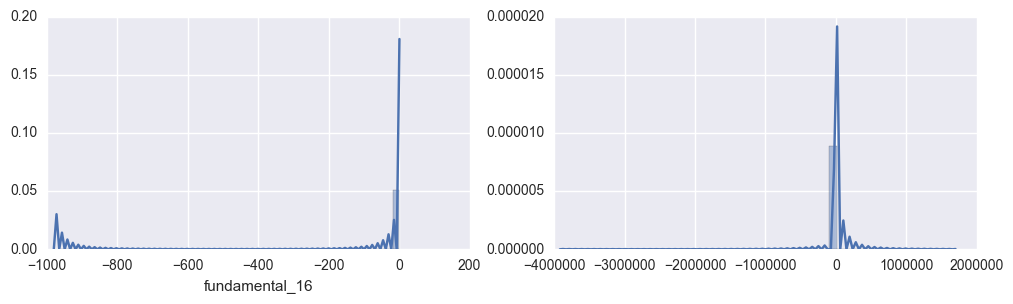

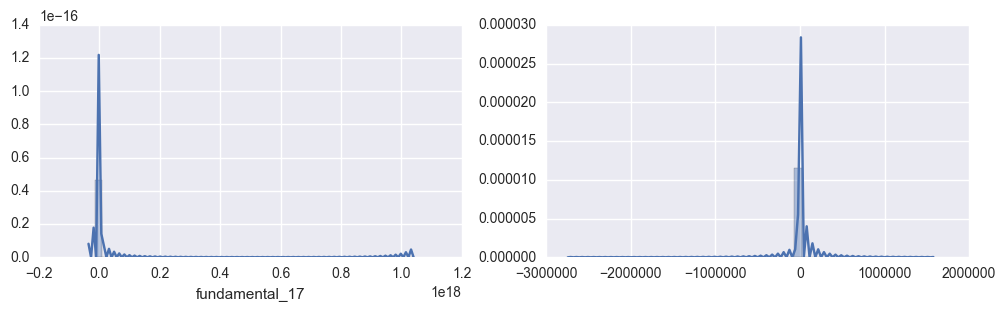

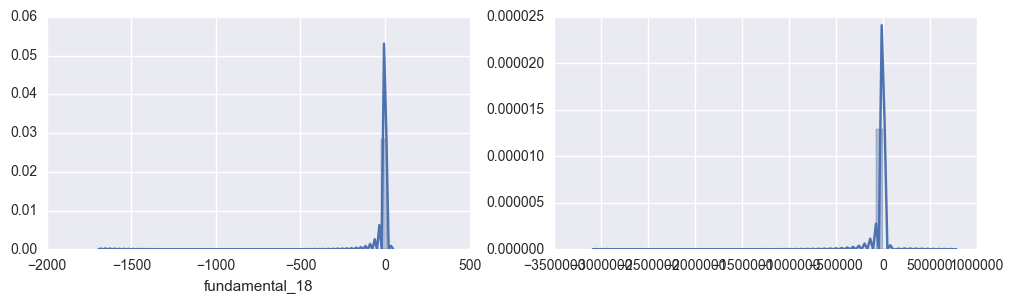

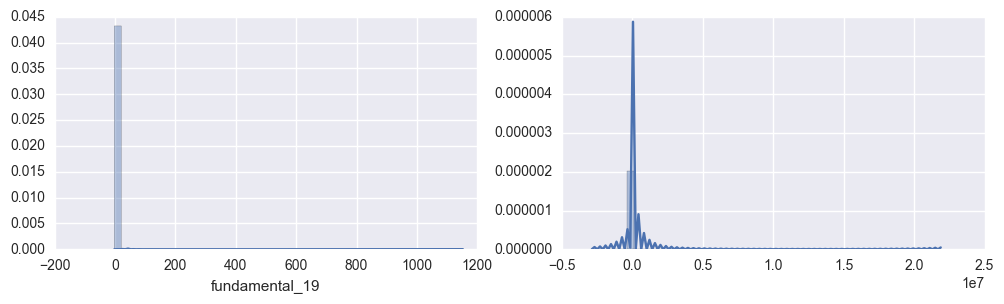

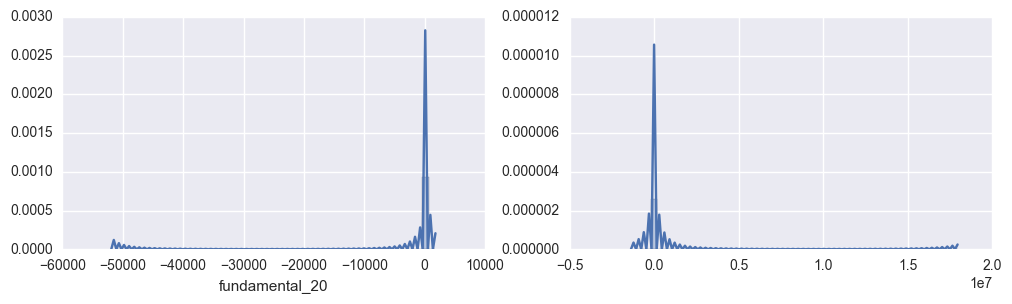

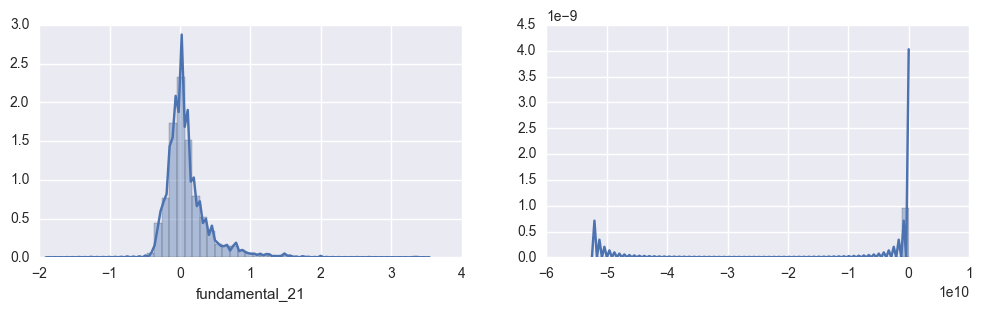

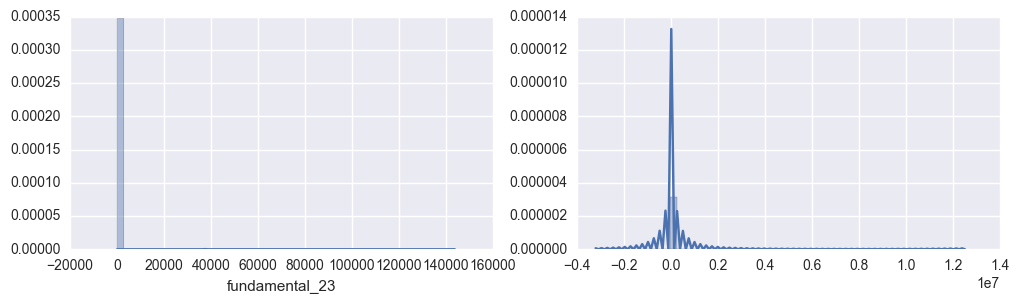

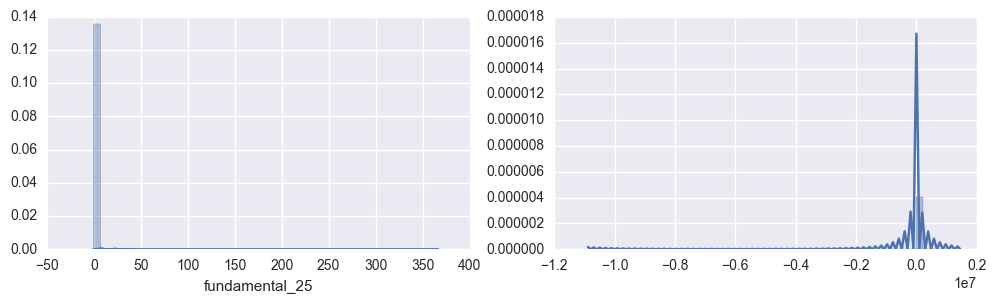

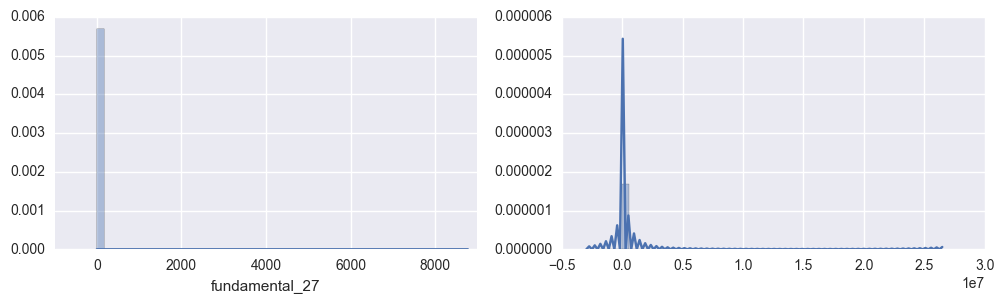

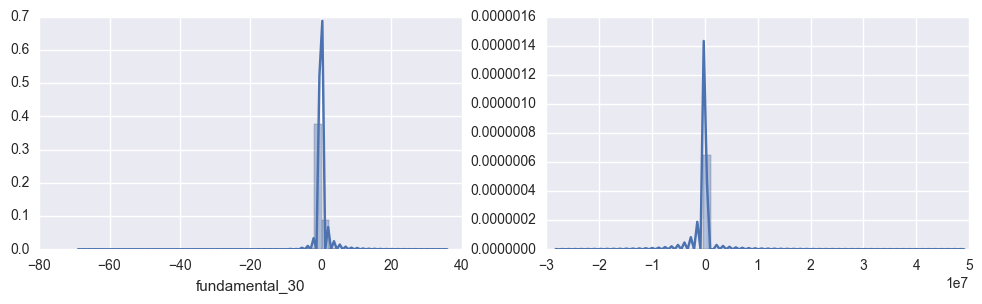

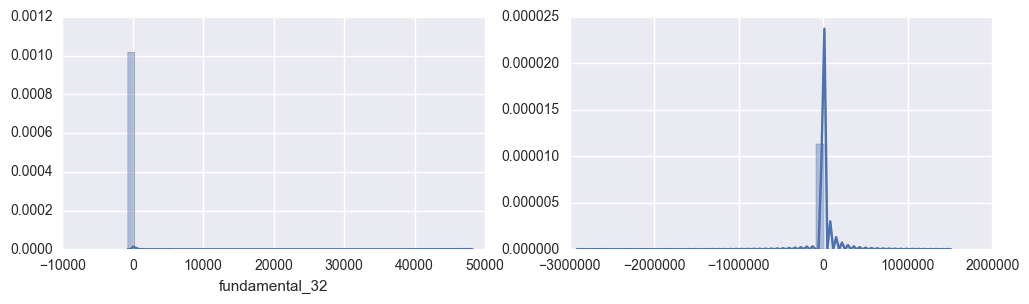

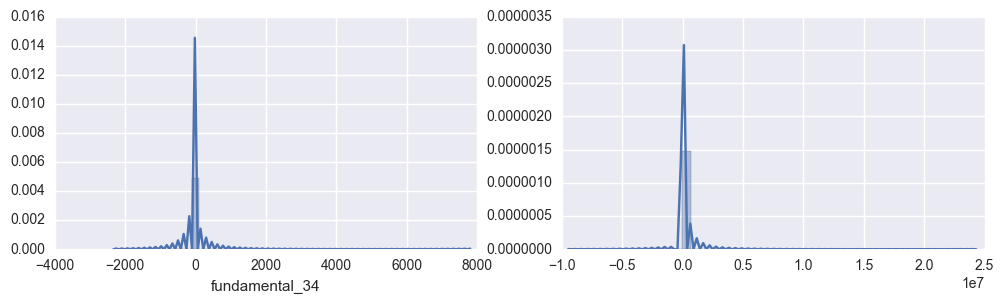

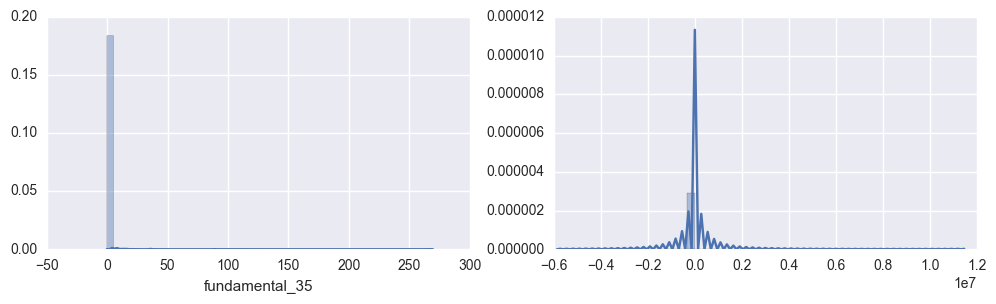

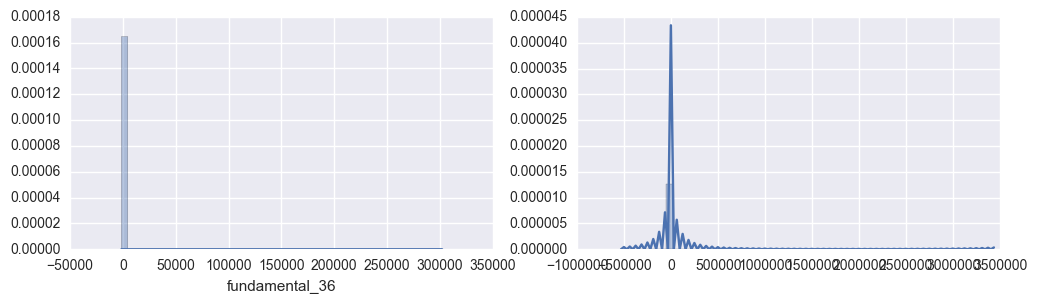

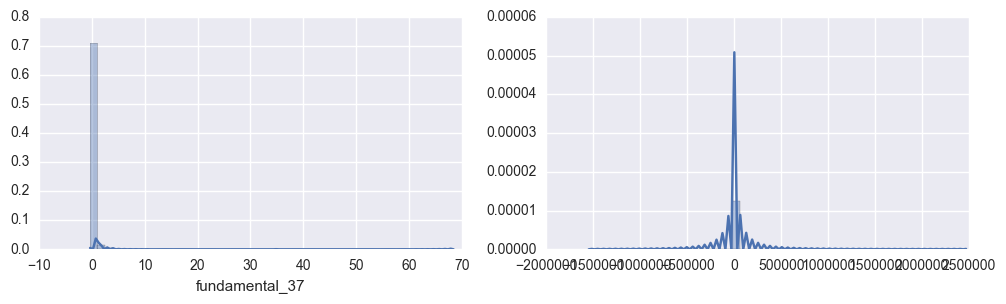

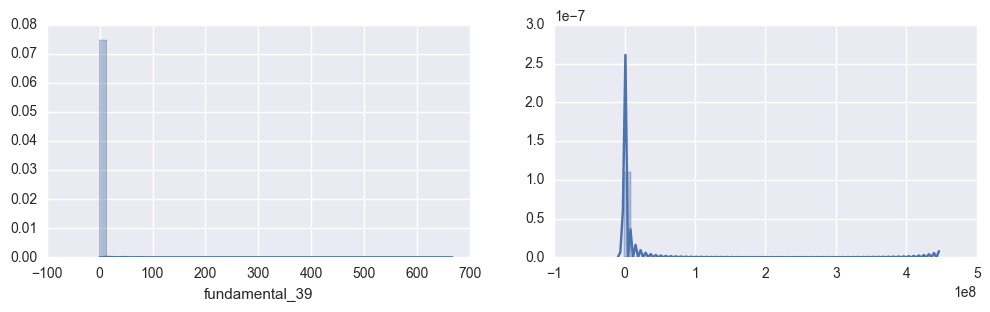

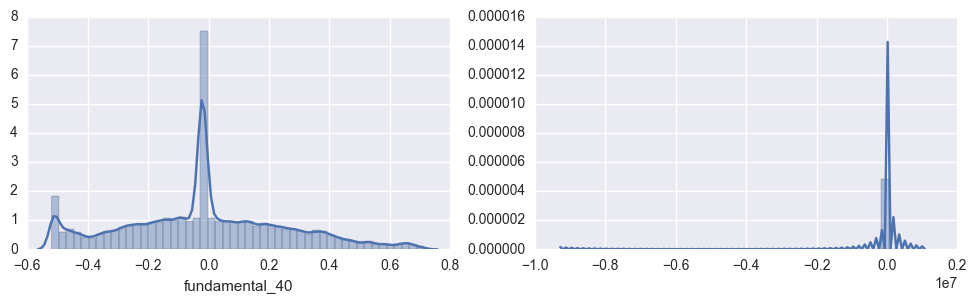

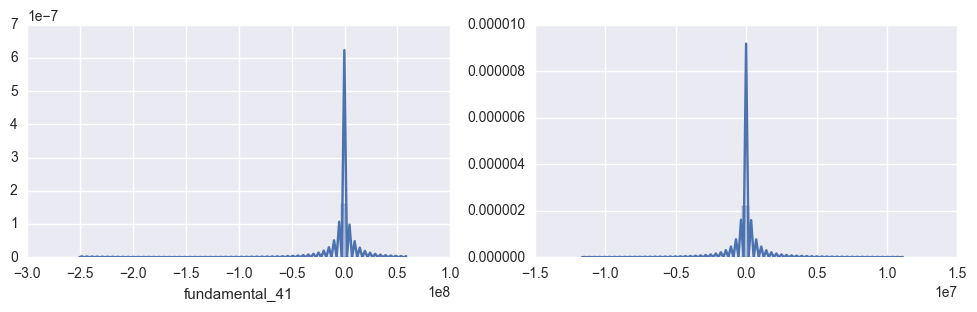

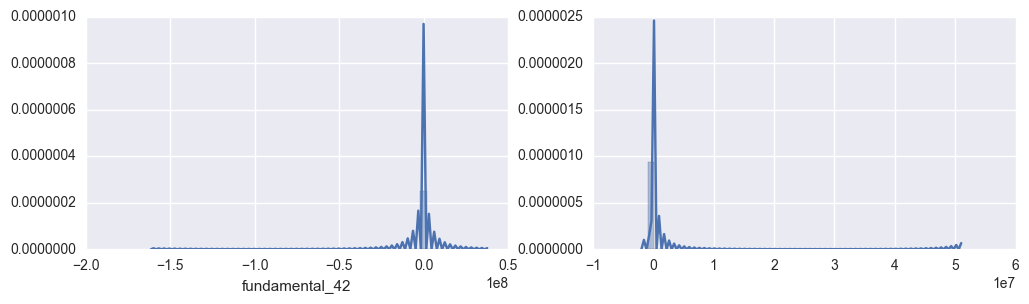

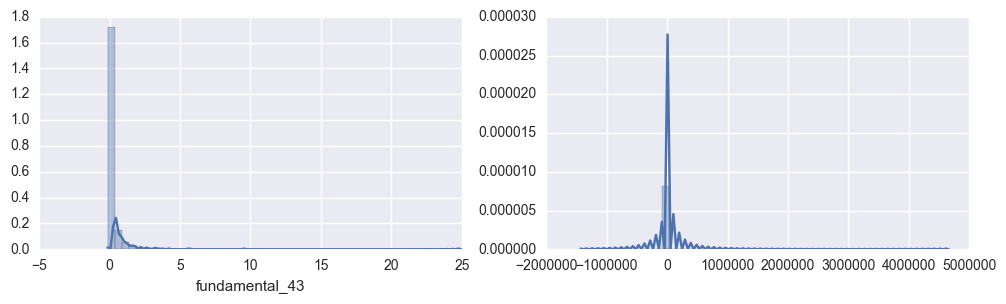

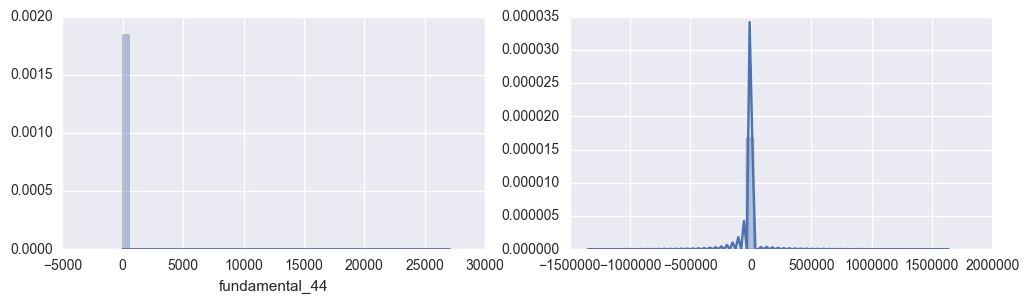

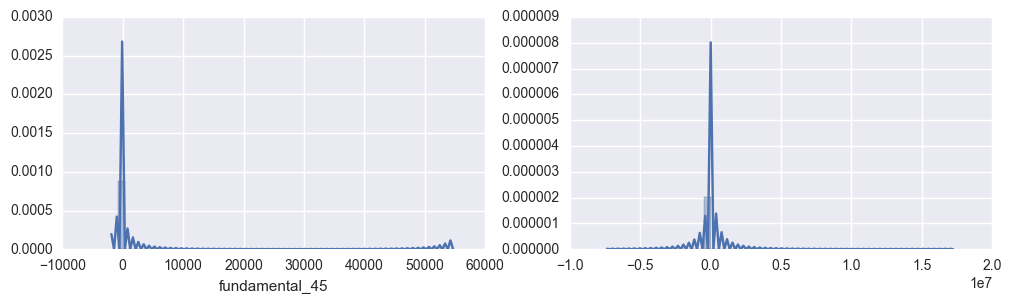

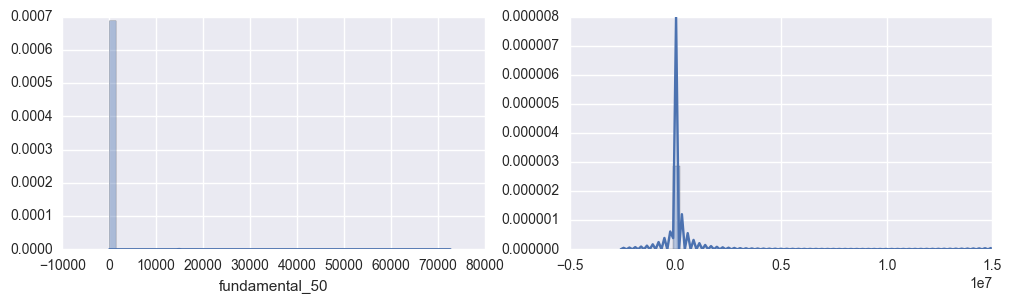

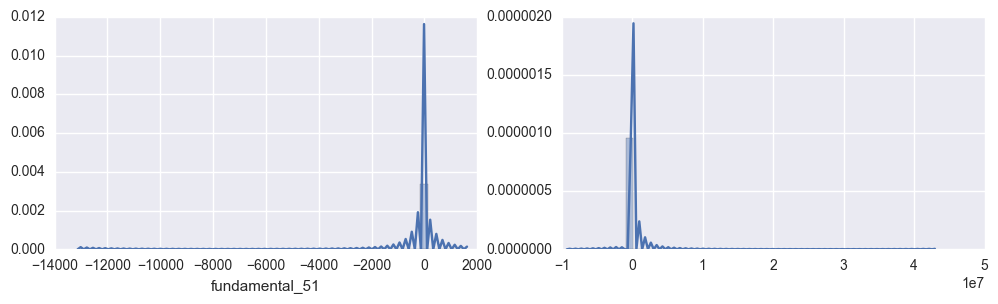

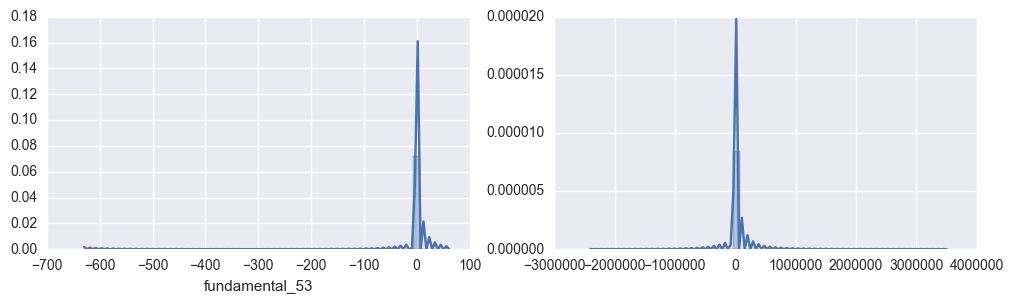

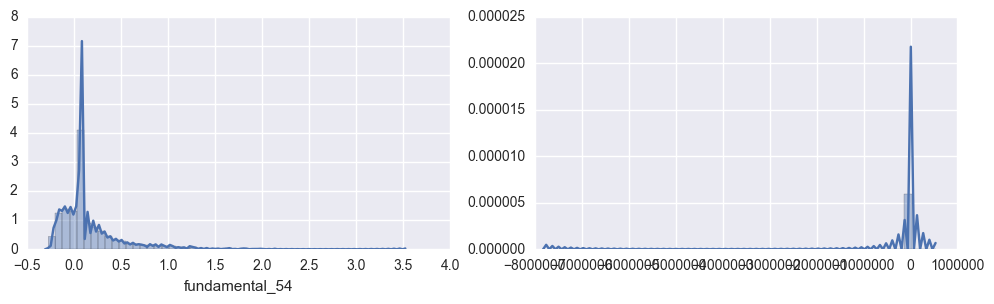

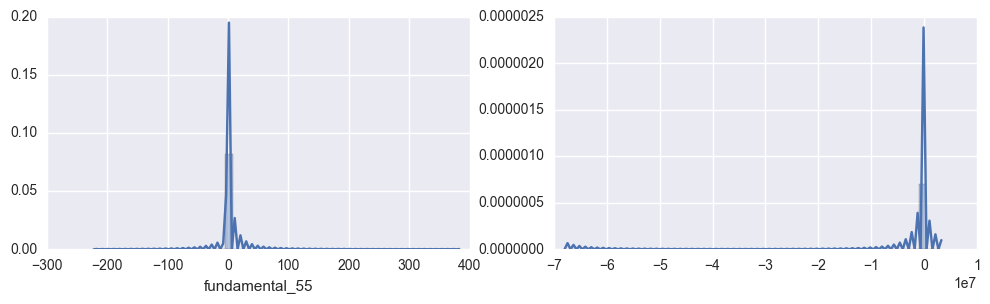

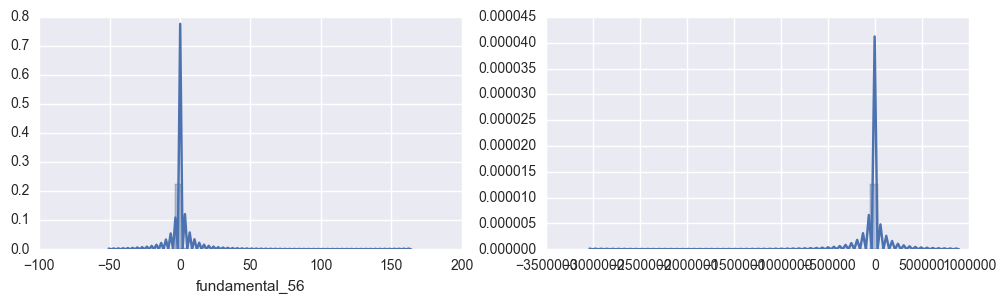

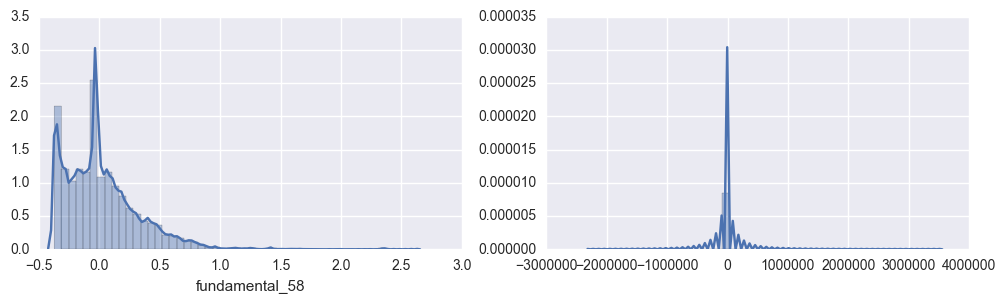

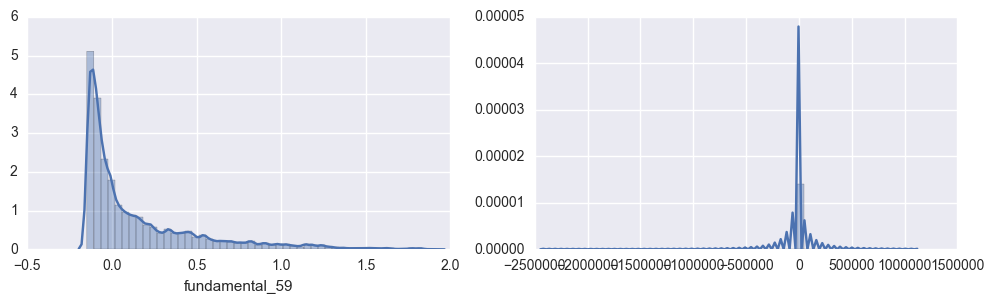

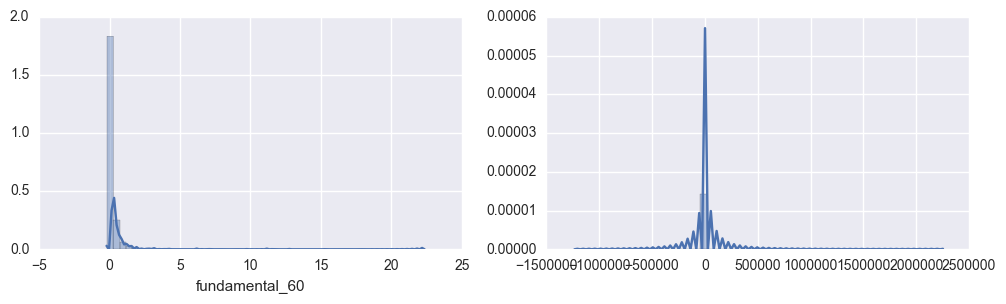

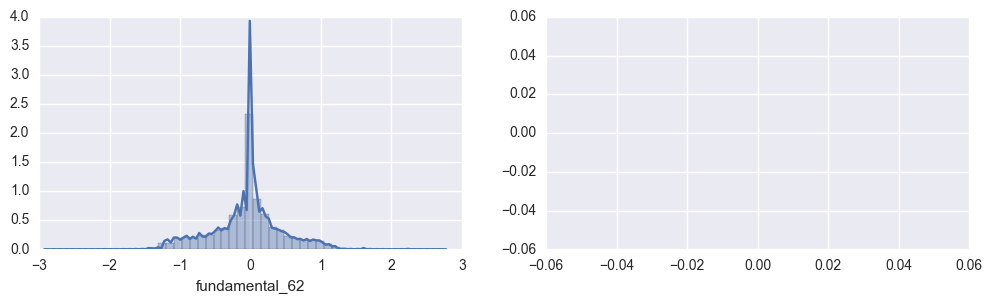

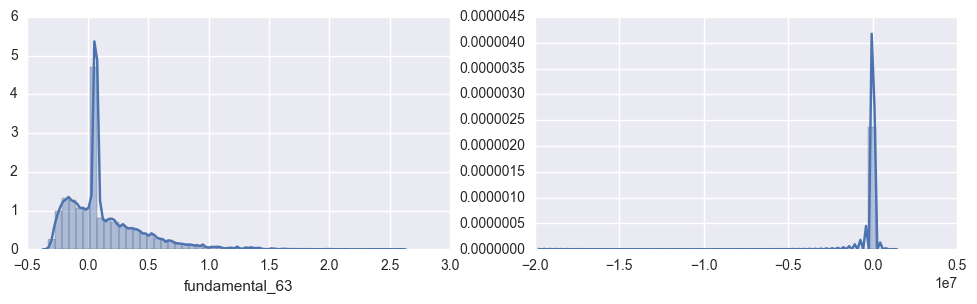

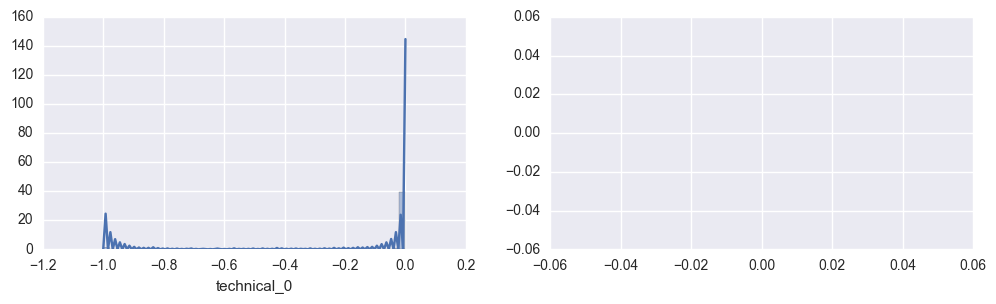

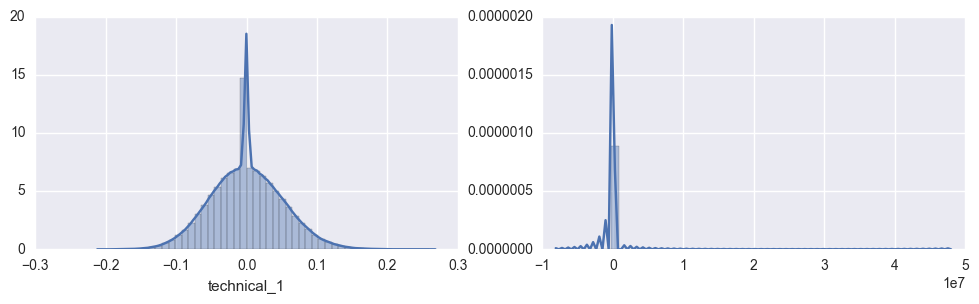

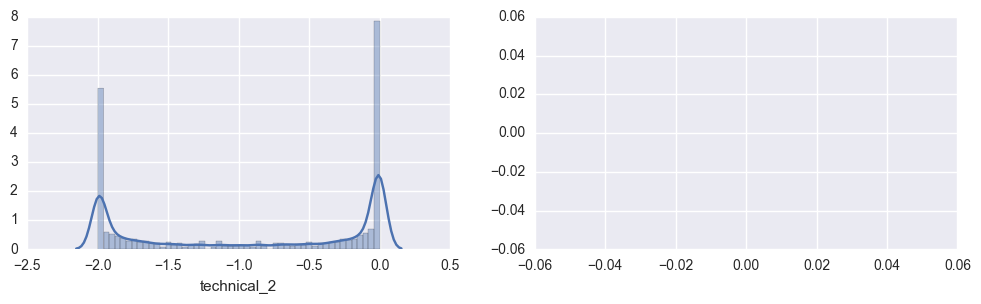

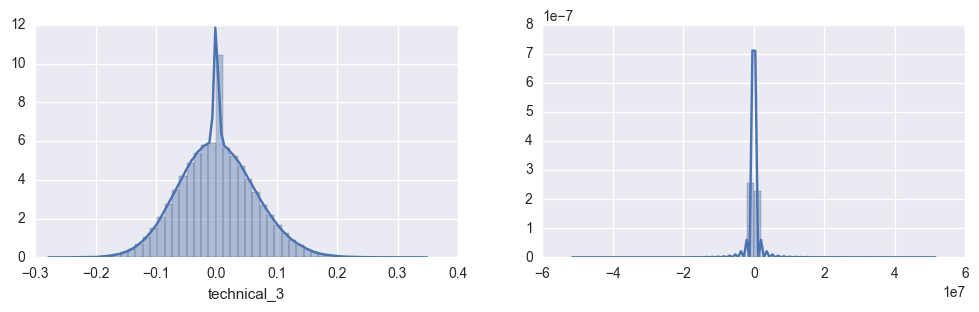

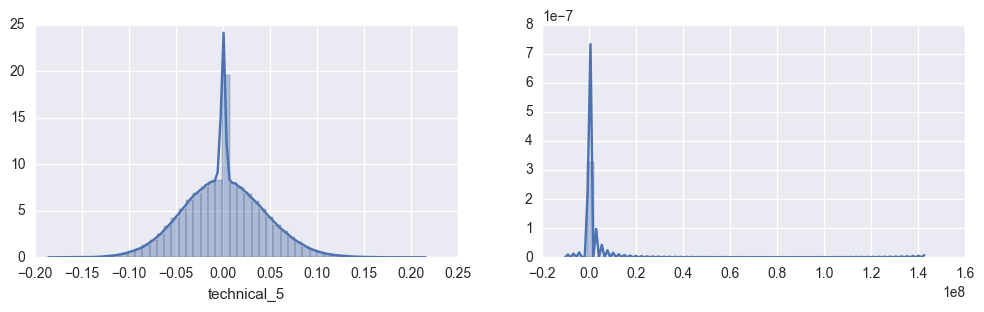

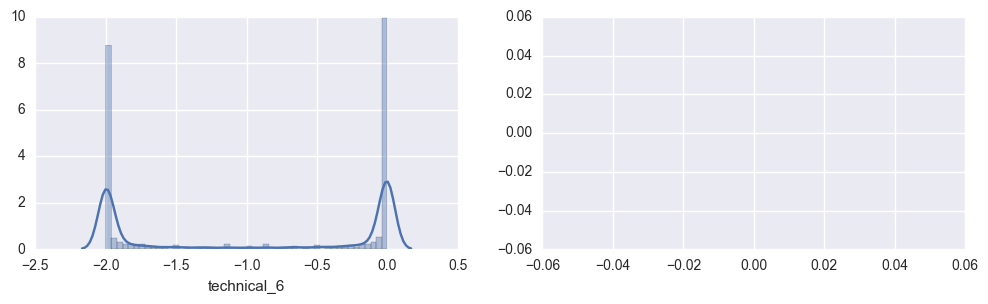

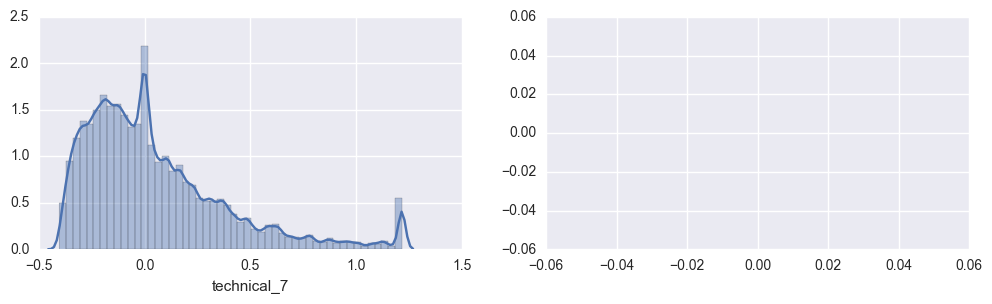

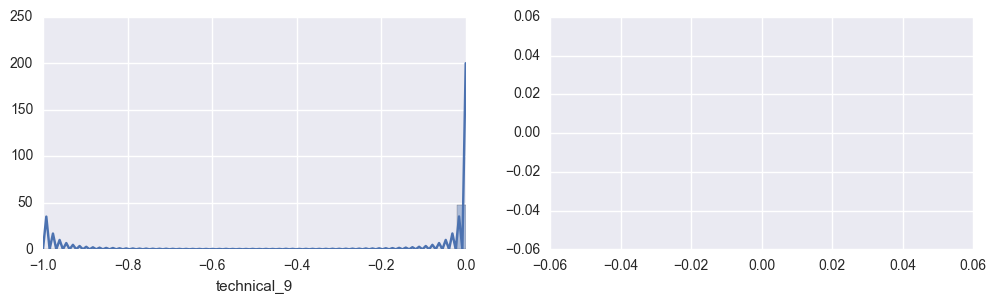

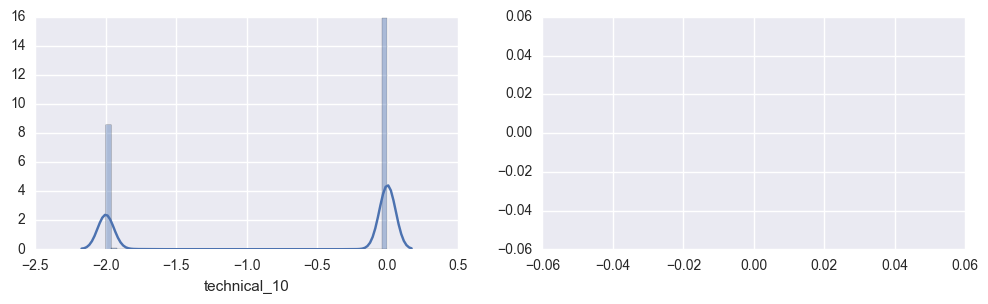

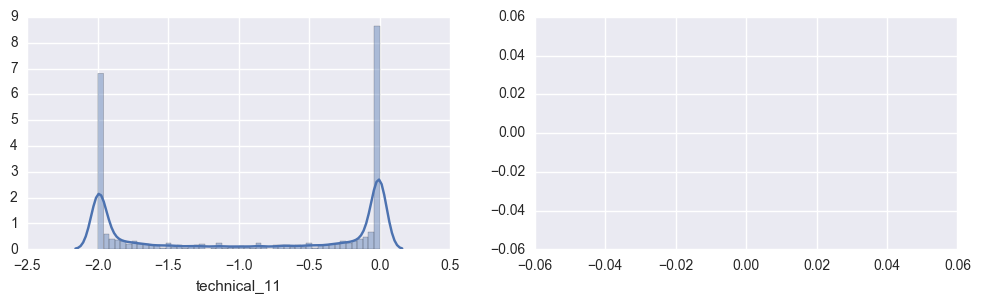

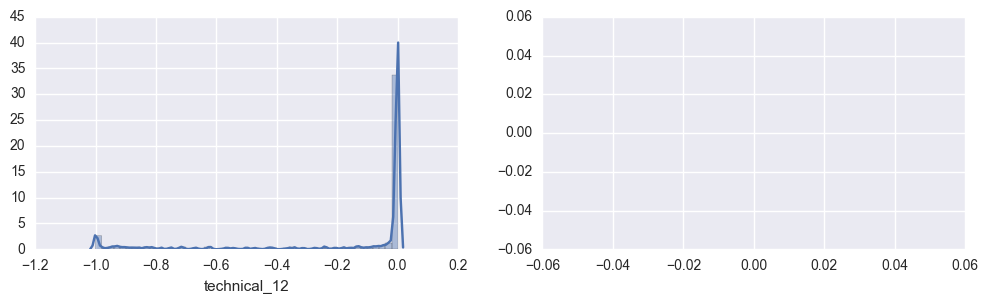

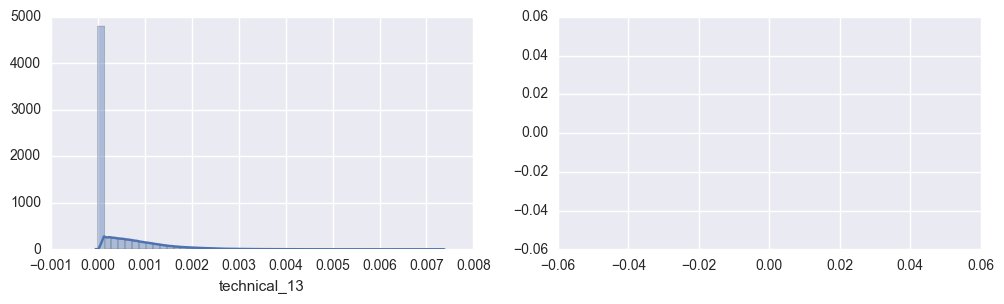

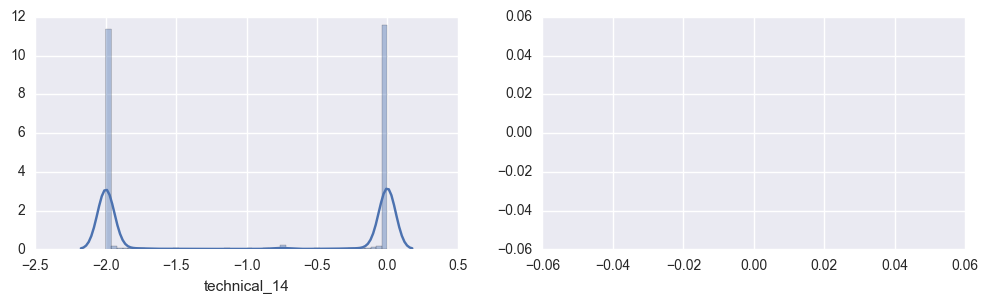

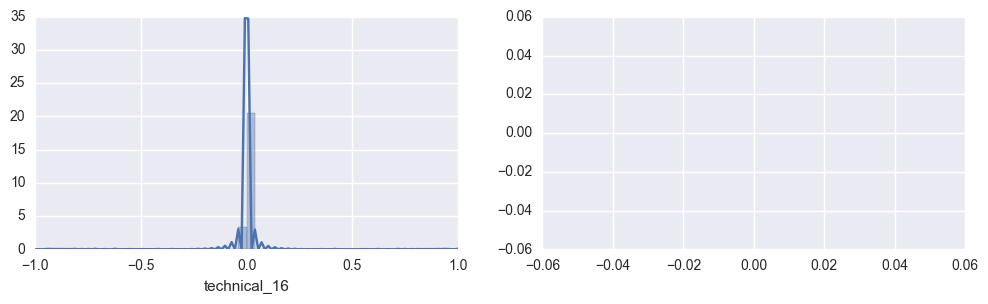

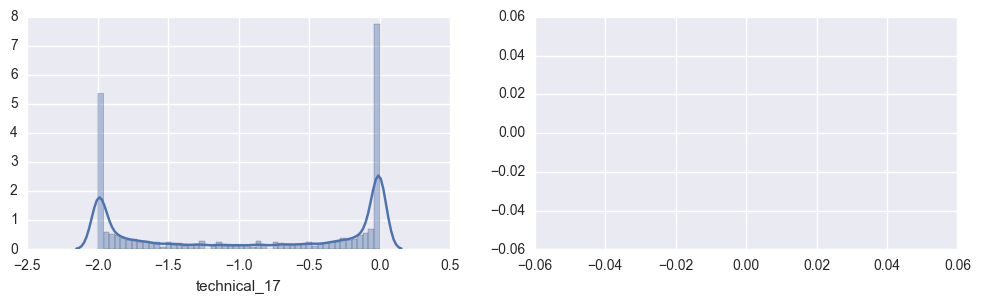

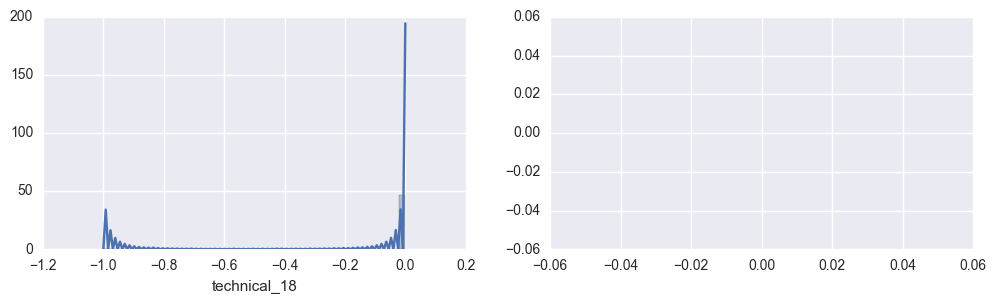

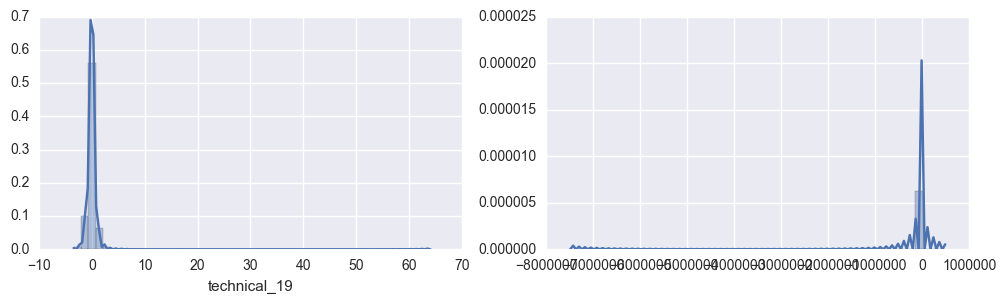

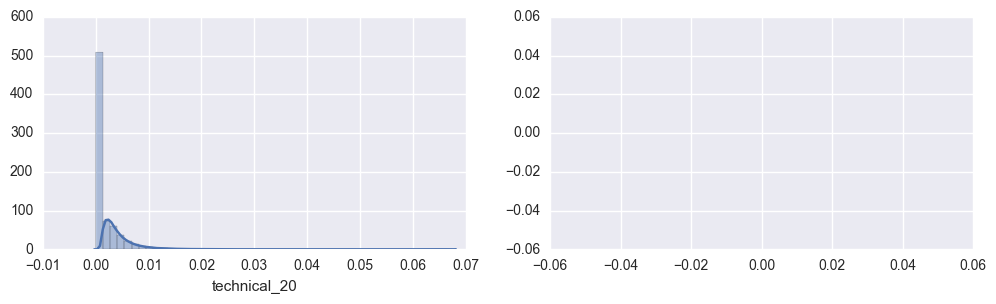

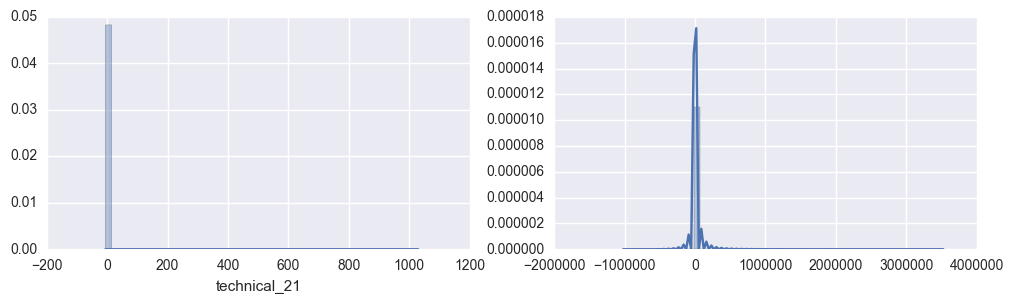

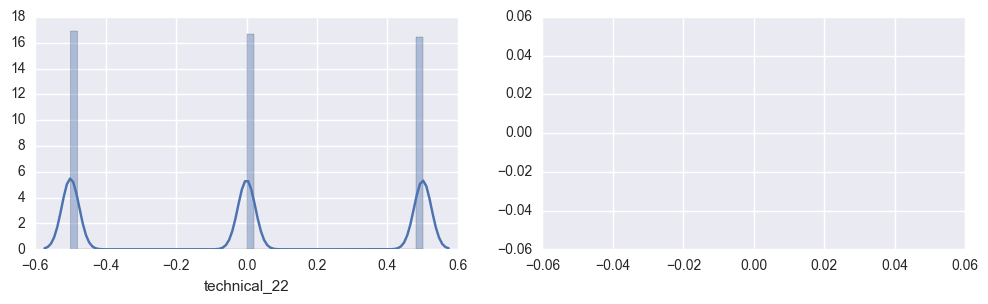

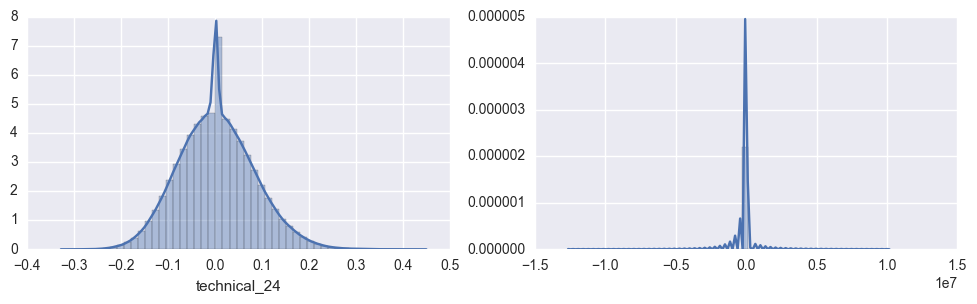

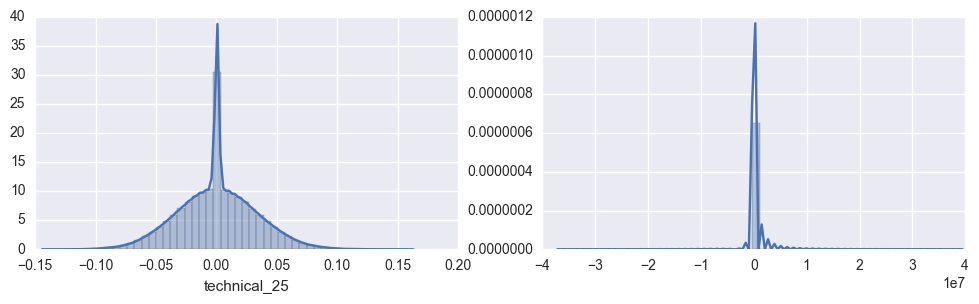

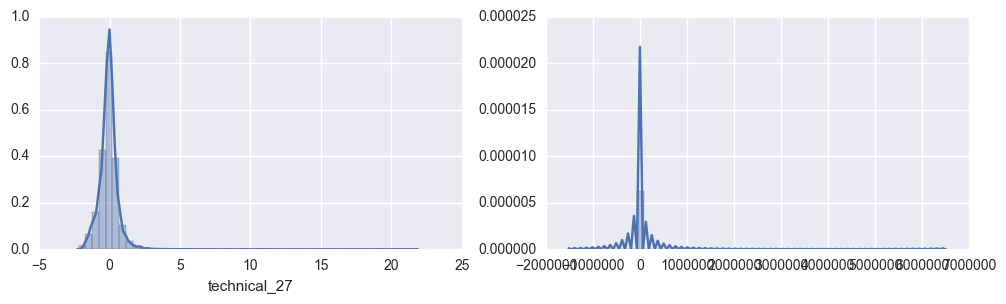

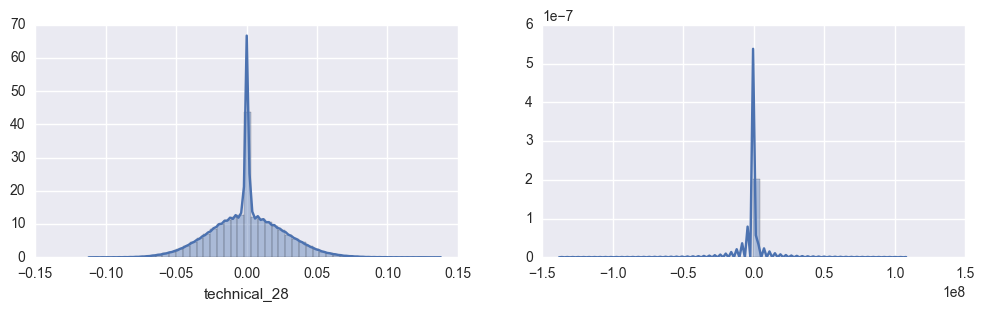

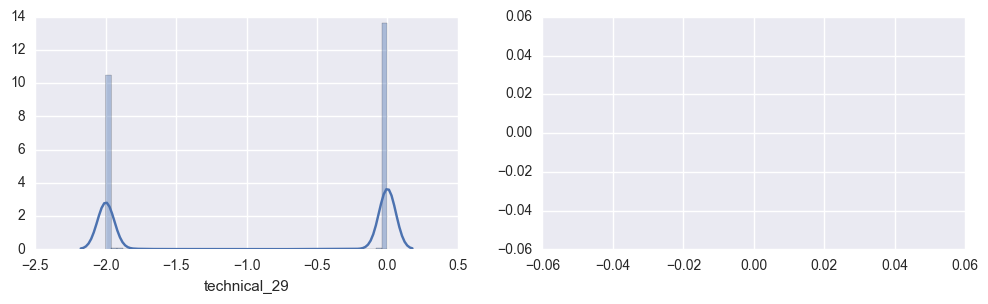

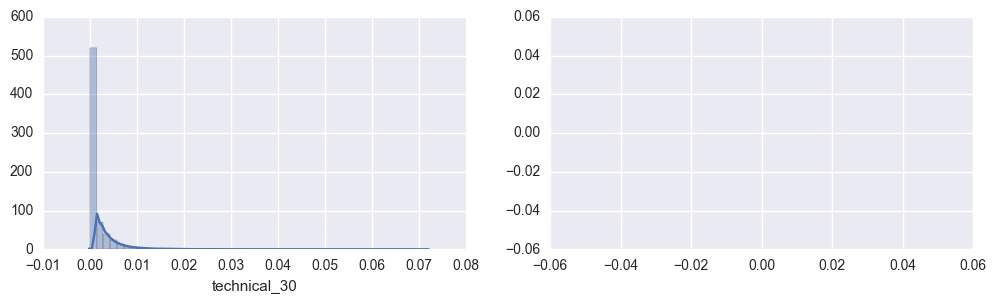

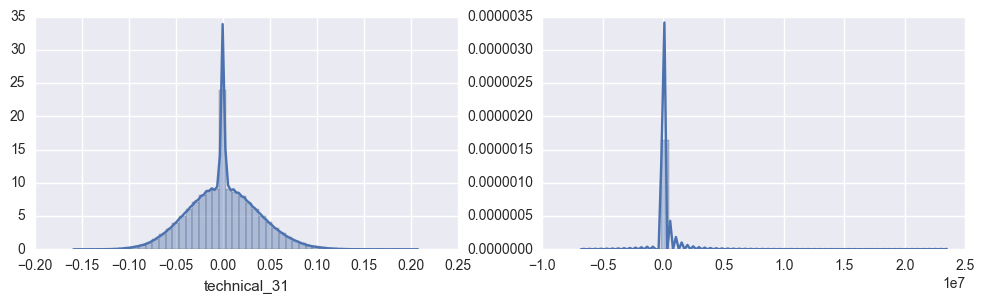

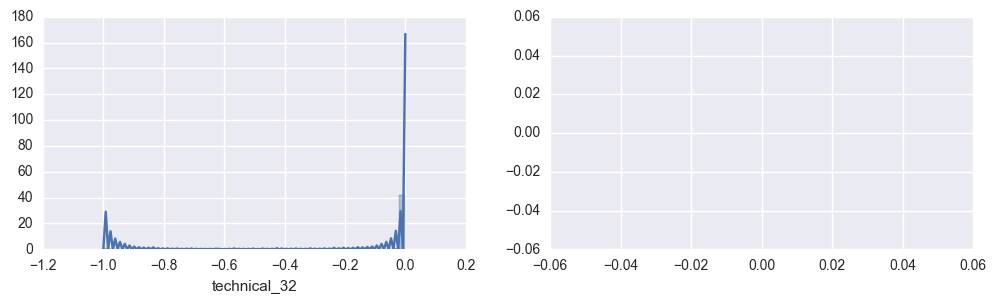

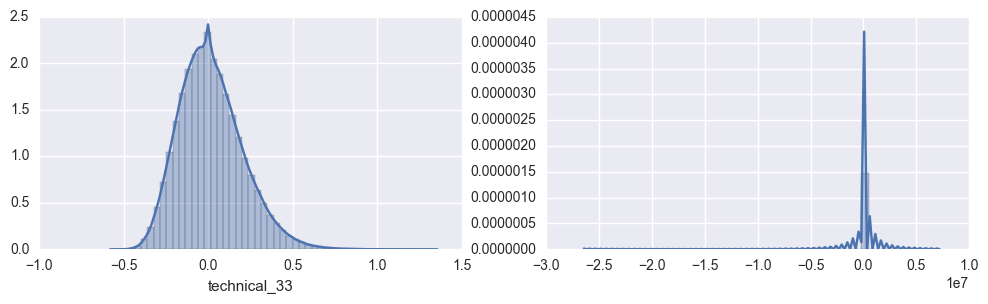

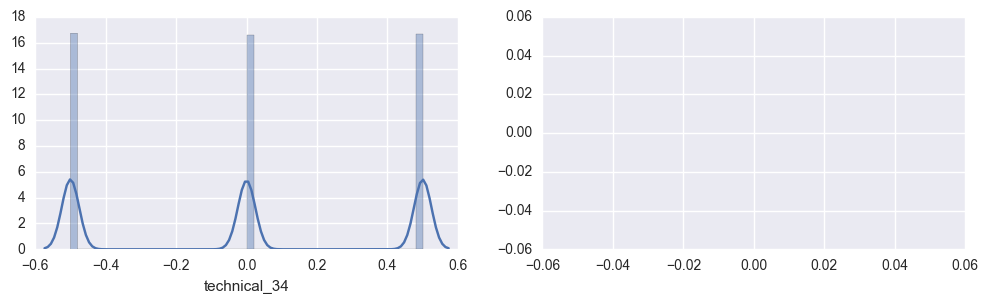

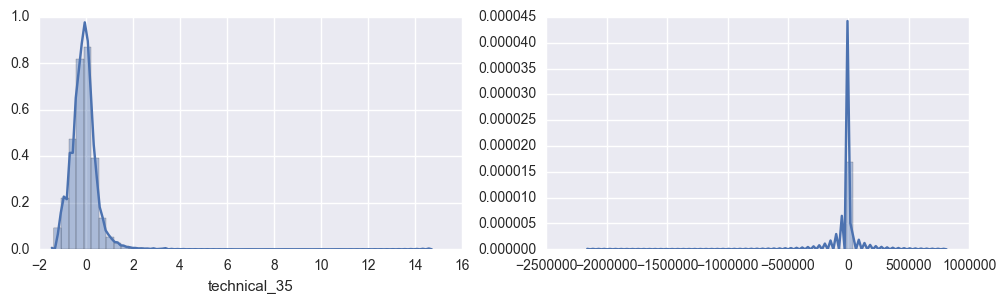

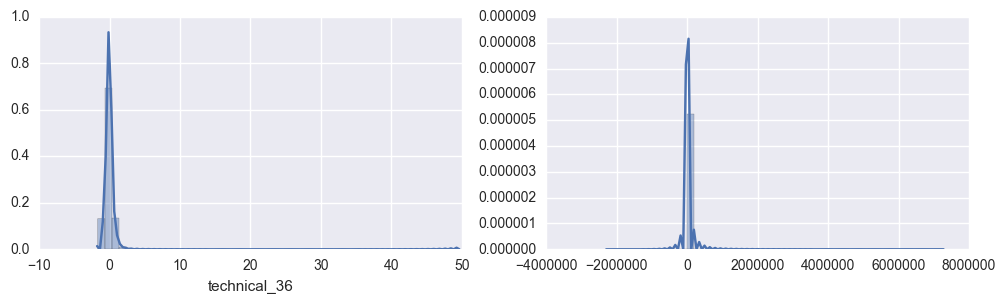

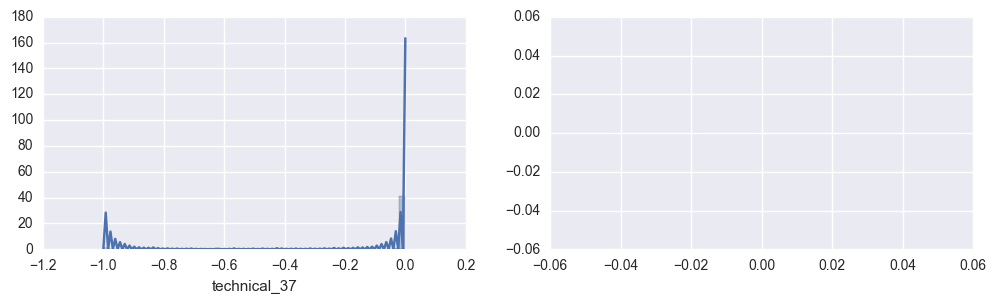

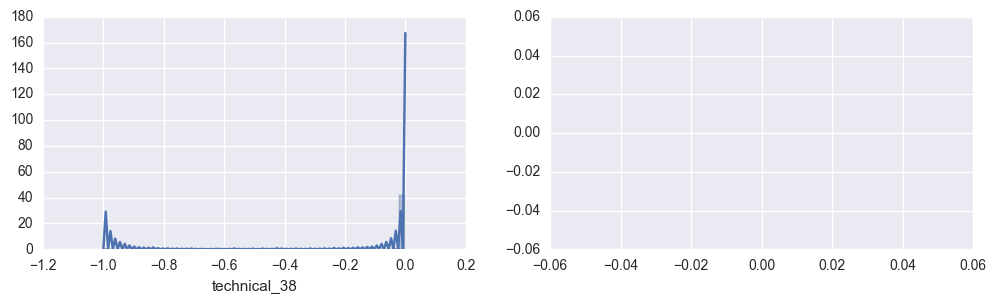

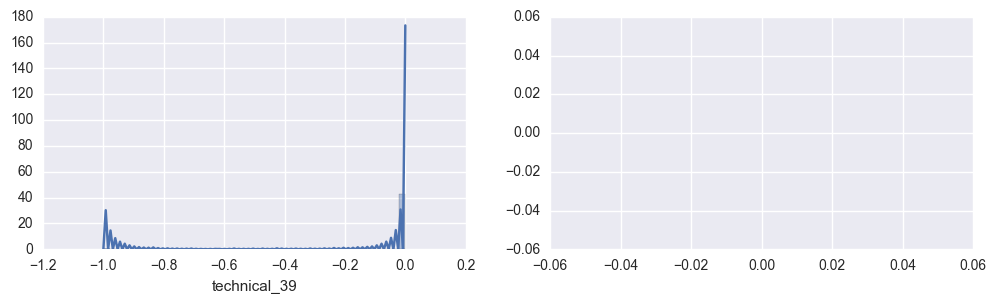

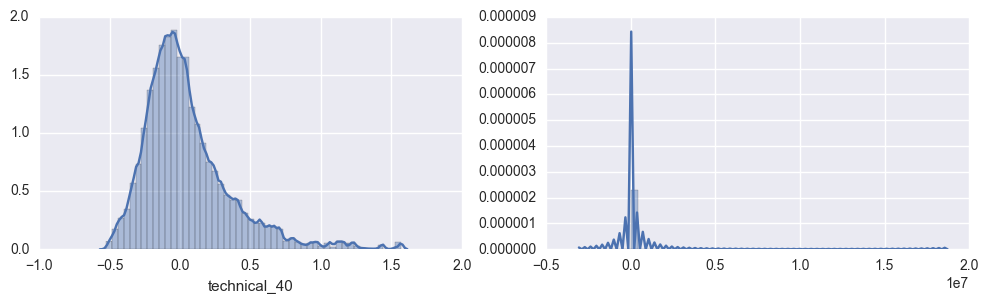

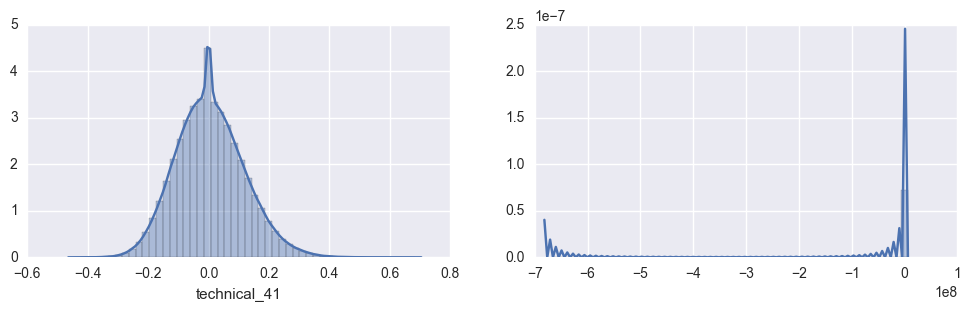

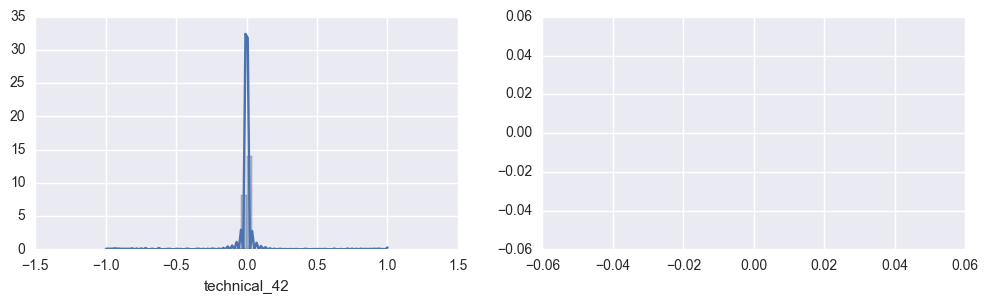

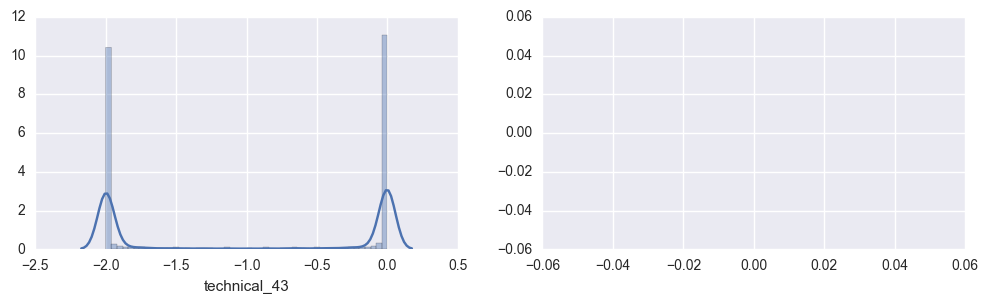

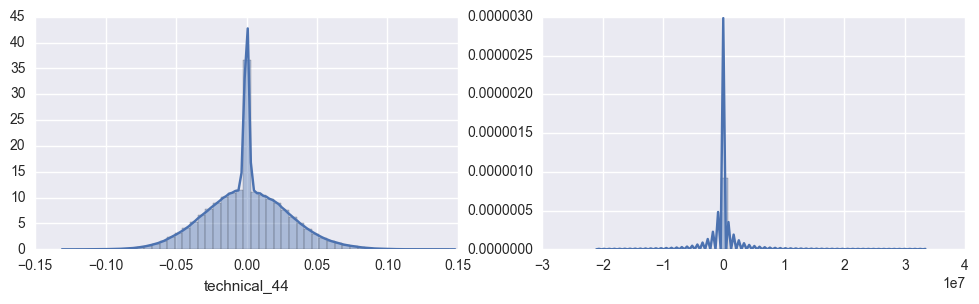

In [16]:
df_transformed = df_filled.copy()
non_transformable_fea = []

for feature in feature_cols:
    try:
        fig = plt.figure(figsize = (12,3))
        ax1 = fig.add_subplot(121)
        sns.distplot(df_filled[feature])
        ax2 = fig.add_subplot(122)
        transformed_list = list(map(lambda x:1/x,df_filled[feature]))
        sns.distplot(transformed_list)
        df_transformed[feature]=transformed_list
    except OverflowError:
        print('%s transformation meet a overflow error'%feature)
        non_transformable_fea.append(feature)
    except ValueError:
        print('%s transformation meet a Value error'%feature)
        non_transformable_fea.append(feature)

In [25]:
## add col to indicate if the value is outlier or not

def mad_based_outlier(points, thresh=3.5):
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh

for feature in feature_cols:
    df_transformed[feature+'outlier'] = mad_based_outlier(df_filled[feature])

## print the dimension of the input features
print('till now , we have %d features'%(len(df_transformed.columns)-1))

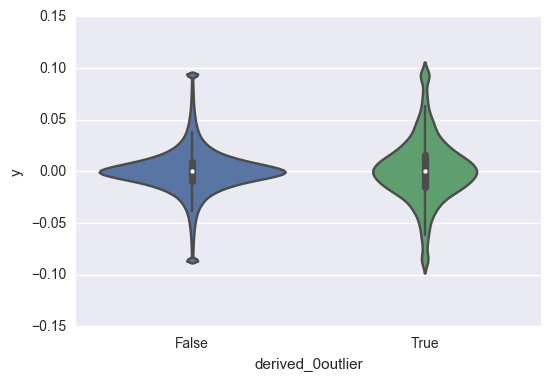

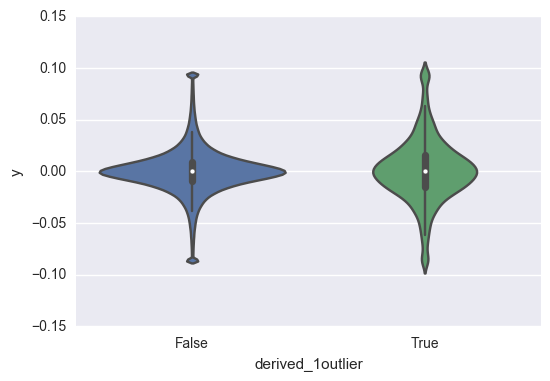

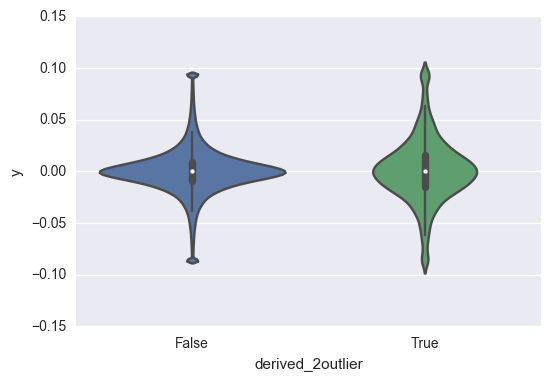

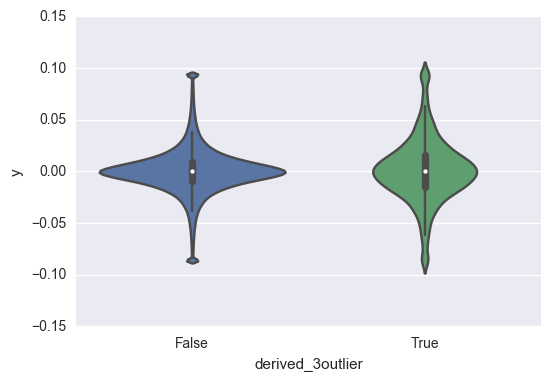

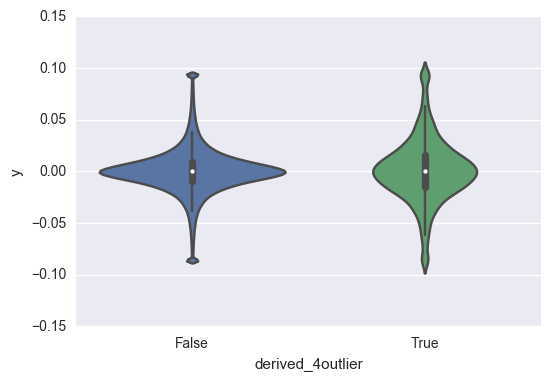

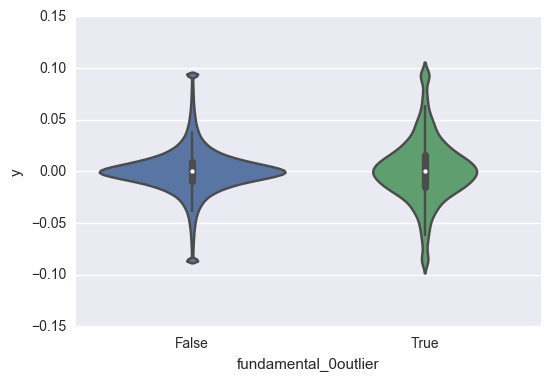

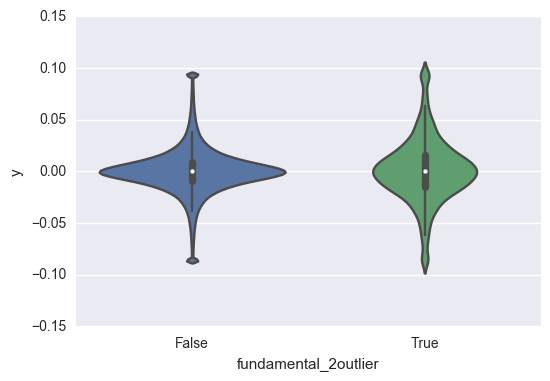

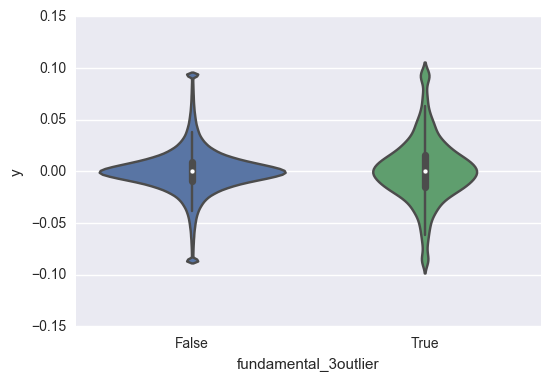

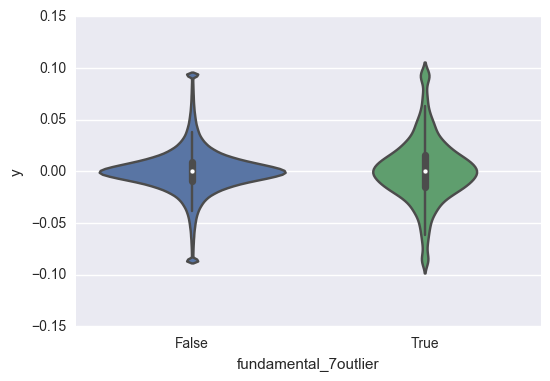

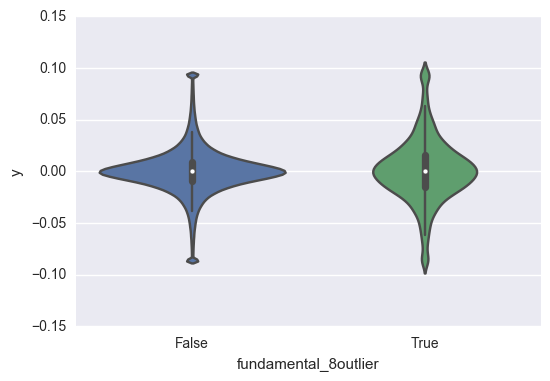

In [36]:
# check univariately if the outlier category have effects on y value
n = 0
for feature in df_transformed.columns:
    if 'outlier' in feature:
        n+=1
        plt.figure()
        sns.violinplot(x=feature, y="y", data=df_transformed)
    if n>=10:
        break

In [39]:
df_shuffled

id  timestamp    derived_0   derived_1   derived_2   derived_3  \
0         797        260   -12.524064  -16.967386   47.404485   10.160644   
1        1677       1582    -9.530091   94.750724    5.360682   -3.543989   
2        1019        338     8.763955   26.515179   11.590753   -6.441856   
3         580        356    -5.022391  -29.065149   77.127516  -78.990484   
4        1036         69   -31.583120    4.173087   -0.588276   -4.288424   
5         235         34     2.219860   23.886712    5.429184  -59.616759   
6        1103       1676    21.082806  -49.845702 -102.797150    1.882560   
7         257        637     1.553547   12.228335   -1.509105    1.993854   
8        2008        911     1.103947  106.706085  -12.375065   11.112802   
9        2068       1195     3.875716 -205.896740   -1.332721   -1.340994   
10       1422        243    51.448416  -20.668913   47.404485  -87.599777   
11        637        628   -18.821099  -33.308472   -3.035445    1.761437   
12       1673       1462 -1194.989906  181.059112   -1.126479  403.940125   
13       1408        703     1.296309    1.668978   -0.885100   -8.764831   
14        319       1625    -0.991877  106.918389   47.404485   -8.177010   
15        833        861    -0.631192  -88.314718  175.484742   51.787894   
16        329       1147     2.810694   24.022581    2.982390   37.066212   
17        881       1755    -0.744772    8.874021   47.404485  -55.184364   
18       2129        706     3.548261  -34.036981   47.404485    1.593470   
19       2134        741     6.556664   74.426929   -2.161436    1.664331   
20        159       1393   -13.730770  -24.185675  -18.606624    0.525348   
21        585       1710    -3.962643   60.185784   47.404485   23.020254   
22       1772       1715    -9.154014   13.597649    6.854838  -38.069158   
23        979        271    -7.822406    5.443925   -1.420731    2.647968   
24       1578       1321     1.957168   17.063182    4.790502  496.402160   
25       1536       1317   -55.298888 -138.267399   -9.448730   -6.256832   
26       1688        628     3.451689    3.756959   -0.417798   -3.468666   
27       2108        560     5.133654   14.947132   47.404485   -6.499820   
28        340        939    13.171203   47.845986  -14.055209  -17.669671   
29        686        646    -1.320762   19.308875  -21.664124   -5.022802   
...       ...        ...          ...         ...         ...         ...   
1710726   429       1534     0.370625   88.033092   47.404485    2.088311   
1710727  1093       1750     6.854136   39.001501    0.706034    3.459619   
1710728  1230       1076   149.615084  -21.993804   47.404485   14.155504   
1710729  1194       1195    35.551403  -51.129750  625.433873    4.322442   
1710730  1296       1768    -3.675029  -18.969781   47.404485   -0.679901   
1710731   765       1217   -14.919566   36.775451   47.404485   -1.385127   
1710732  1677        577    22.459164   41.441018    4.329614   14.100866   
1710733  1139        926 -1194.989906  181.059112   47.404485  403.940125   
1710734   952       1637    -1.829972    4.088671    2.826257    2.739275   
1710735   481        893  -197.912010  -33.074600  -32.232419  350.975277   
1710736   863        583   125.082674  -15.977626   47.404485   -1.219332   
1710737  1225       1756    -4.126209  -20.217042  -15.405387  -12.290016   
1710738   686        797     2.402908   98.140416 -210.369503   -7.793065   
1710739   763        759    -3.328765  -34.383870   47.404485  -10.513963   
1710740  1072       1378    12.678297  -24.209130  -16.757369   -6.591475   
1710741  1566       1812    -5.001350  -41.330254    8.497675   -3.634518   
1710742   396        655   -23.000149   16.531021    3.683535  403.940125   
1710743   938        649     1.242076    3.181002   -0.499901    0.987309   
1710744   938        154     0.793803    2.208780   -0.864721   -0.090009   
1710745   484        983     5.173536  -52.535528   47.404485   10.909958   
1710746

In [ ]:
import pickle
with open('df_filled_transformed.pickle', 'wb') as handle:
    pickle.dump(df_transformed, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('df_filled.pickle', 'wb') as handle:
    pickle.dump(df_filled, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [21]:
## imbalance binary classes: one class contain 5% (84413) while another 95%
print(sum(mad_based_outlier(df['y']))/len(df))
print(sum(mad_based_outlier(df['y'])))

0.0493425129007
84413


In [18]:
len(df.ix[mad_based_outlier(df['y'])].id.unique())

1383

In [19]:
len(df.id.unique())

1424

In [20]:
feature_cols_added = [x for x in list(df_transformed.columns) if x not in ['id','timestamp','y']]

## shuffle the data
from sklearn.utils import shuffle
df_shuffled = shuffle(df_transformed,random_state=0).reset_index(drop = True)

## use isolation forest to detect anomaly

X = df_shuffled[feature_cols]
from sklearn.ensemble import IsolationForest
rng = np.random.RandomState(42)
clf = IsolationForest(max_samples=100, random_state=rng,contamination=0.05)
clf.fit(X)
anomaly_pred = clf.predict(X)

df_shuffled['ano_y_iso'] = anomaly_pred

array([False, False, False, ..., False, False, False], dtype=bool)

In [ ]:
### classification
y  = mad_based_outlier(df_shuffled['y']) #label

feature_cols_all = [x for x in list(df_transformed.columns) if x not in ['y']]

X = df_shuffled[feature_cols] ##use original features to do classification

## deal with imbalance

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier 
from imblearn import over_sampling as os
from imblearn import pipeline as pl
from imblearn.metrics import geometric_mean_score

RANDOM_STATE = 42

pipeline = pl.make_pipeline(os.SMOTE(random_state=RANDOM_STATE),
                            RandomForestClassifier(random_state=RANDOM_STATE))

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=RANDOM_STATE)

# Train the classifier with balancing
pipeline.fit(X_train, y_train)

# Test the classifier and get the prediction
y_pred_bal = pipeline.predict(X_test)

print('The geometric mean is {}'.format(geometric_mean_score(
    y_test,
    y_pred_bal)))

## add another colume to indicate anomoly probability

df_shuffled['predicted_ano'] = pipeline.predict(X)

In [21]:
feature_cols_added = [x for x in list(df_transformed.columns) if x not in ['id','timestamp','y']]
X = df_shuffled[feature_cols]
from sklearn.ensemble import IsolationForest
rng = np.random.RandomState(42)
clf = IsolationForest(max_samples=100, random_state=rng,contamination=0.05)
clf.fit(X)
anomaly_pred = clf.predict(X)

NameError: name 'df_transformed_shuffled' is not defined

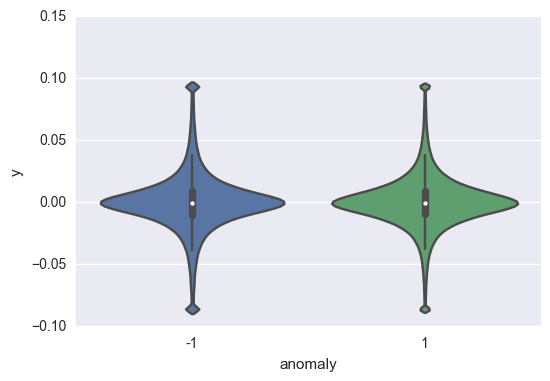

In [22]:
sns.violinplot(x="anomaly", y="y", data=pd.DataFrame({'anomaly':anomaly_pred,'y':df_shuffled['y']}))

C:\Users\Miya\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


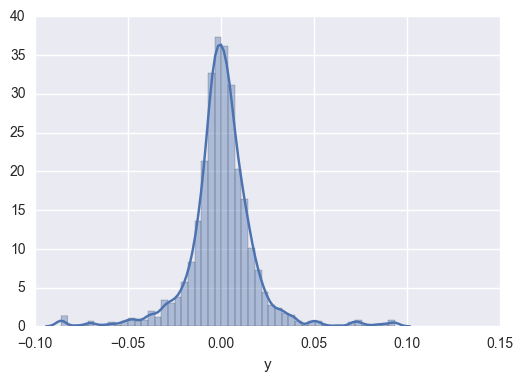

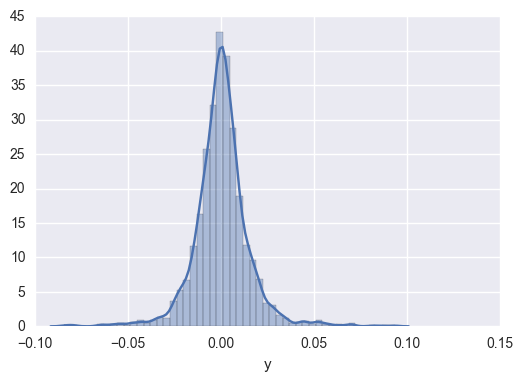

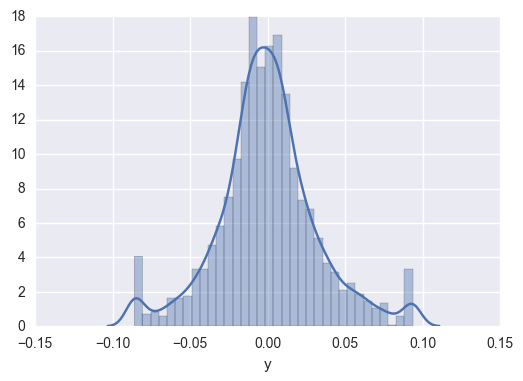

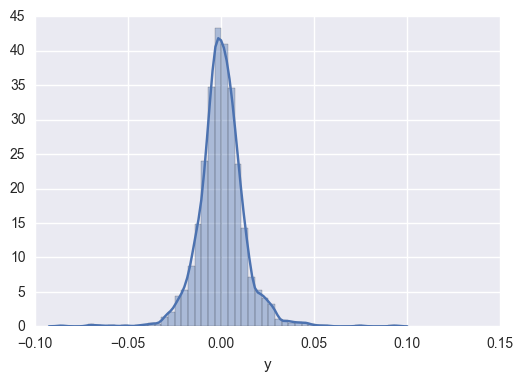

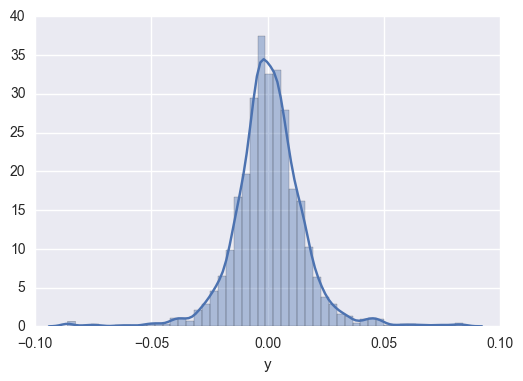

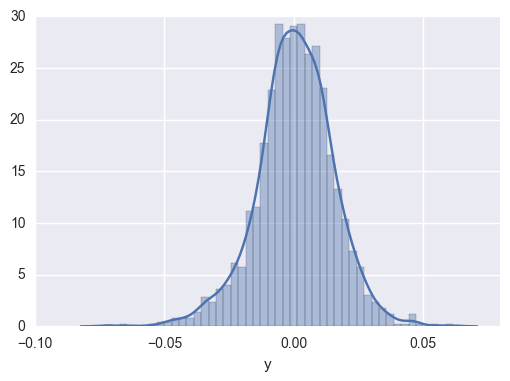

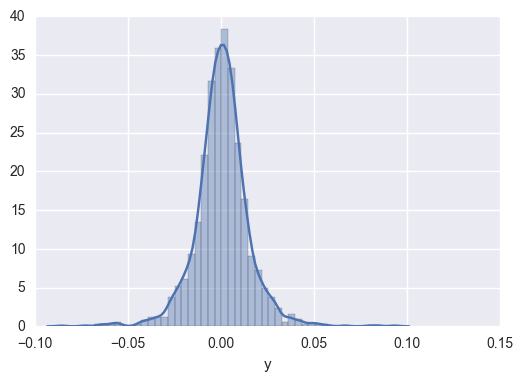

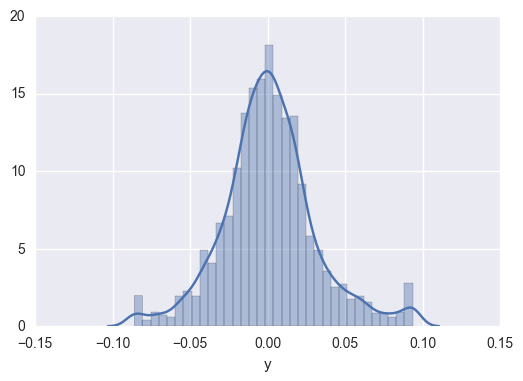

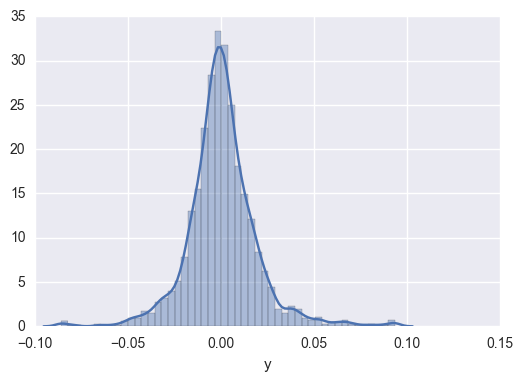

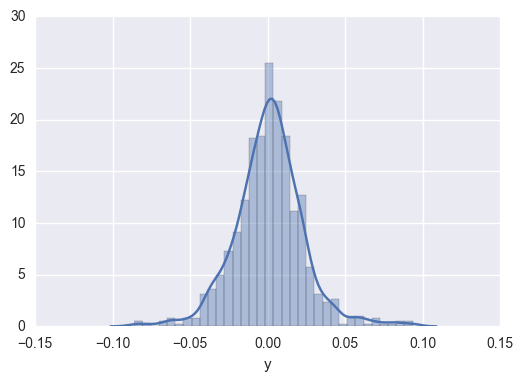

In [24]:
n = 0
for nindex in df_shuffled['id'].unique():
    plt.figure()
    sns.distplot(df_shuffled[df_shuffled['id']==nindex]['y'])
    n+=1
    if n>=10:
        break

In [ ]:
import pickle
with open('df_filled_transformed_shuffled.pickle', 'wb') as handle:
    pickle.dump(df_shuffled, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('df_filled.pickle', 'wb') as handle:
    pickle.dump(df_filled, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [3]:
dfId = df[['id', 'timestamp', 'y']].groupby('id').agg([
                    np.min, np.max, len, 
                lambda m: (list(m)[0] - list(m)[-1])/np.abs(np.mean(list(m))) ]).reset_index()

In [7]:
timestamp_cnt = df[['id', 'timestamp', 'y']].groupby('id').count().sort_values(by = 'y',ascending = False)

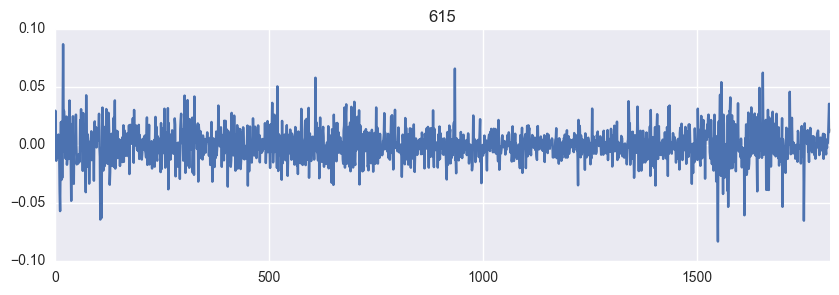

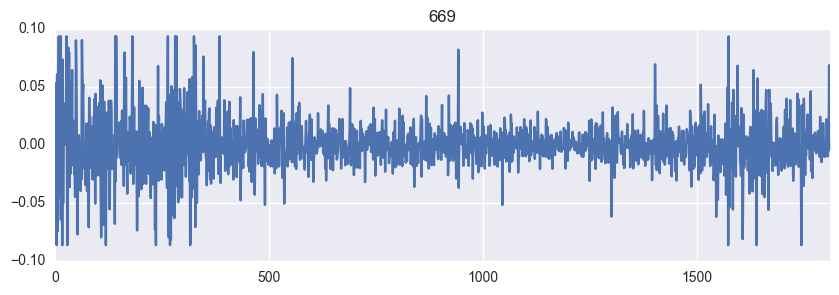

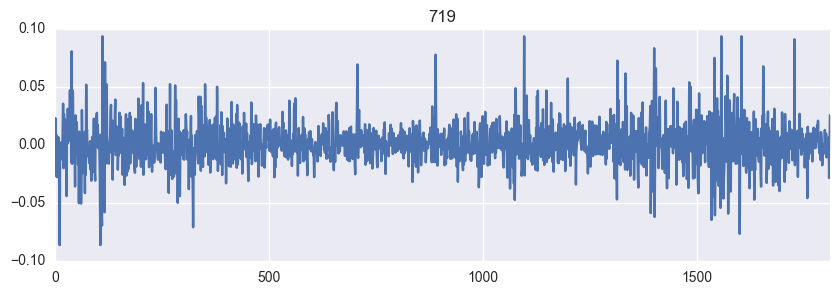

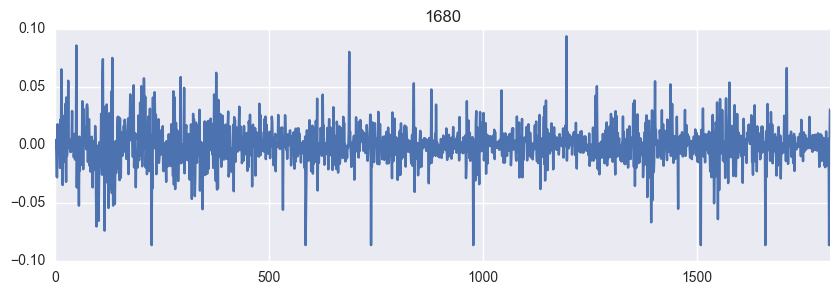

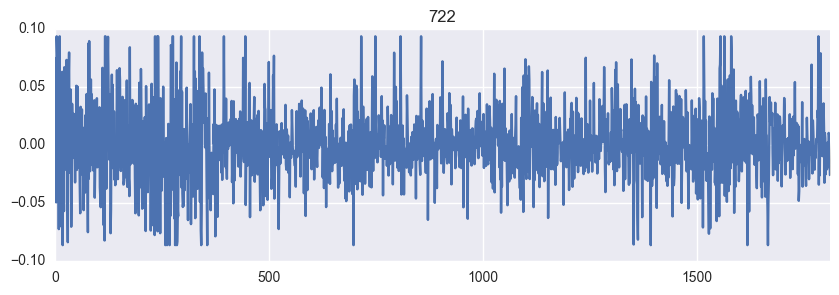

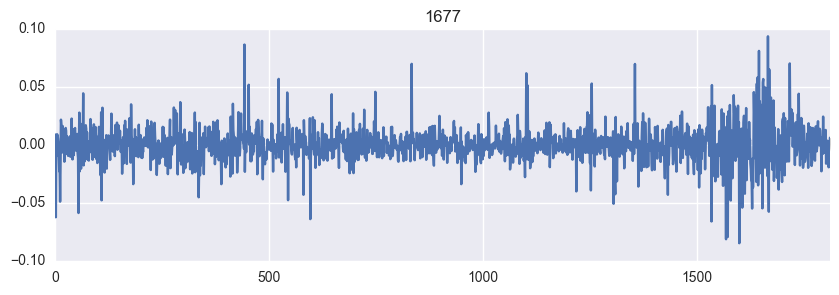

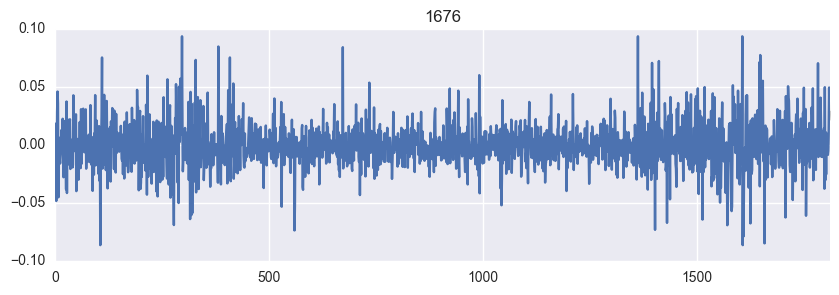

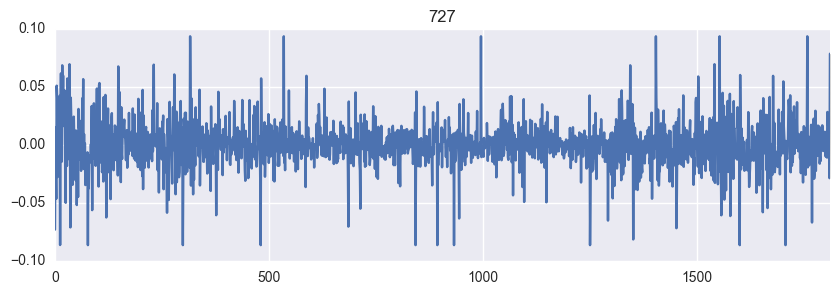

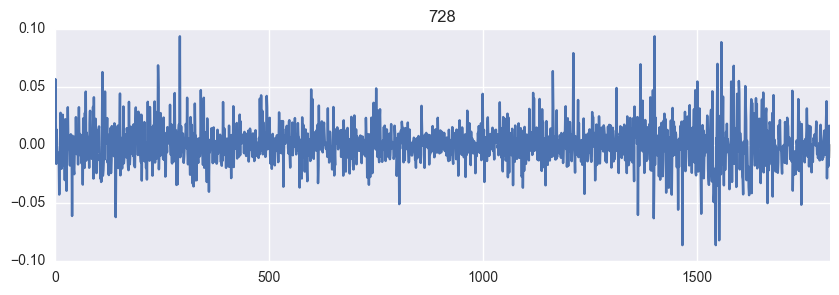

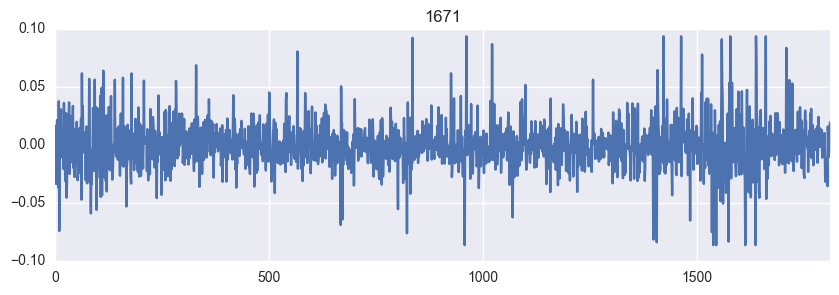

In [19]:
n = 0
for idex in timestamp_cnt[timestamp_cnt['y']==1813].index:
    plt.figure(figsize=(10,3))
    plt.title(idex)
    n +=1
    sns.tsplot(data = df[df['id']==idex]['y'])
    if n>=10:
        break

C:\Users\Miya\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=60,center=False).mean()
  if __name__ == '__main__':


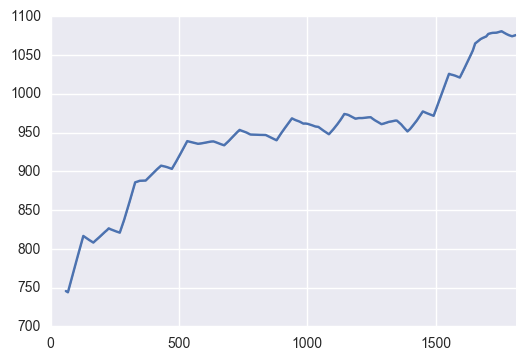

In [36]:
sns.tsplot(data = pd.rolling_mean(df.groupby('timestamp').count()['y'],window = 60))

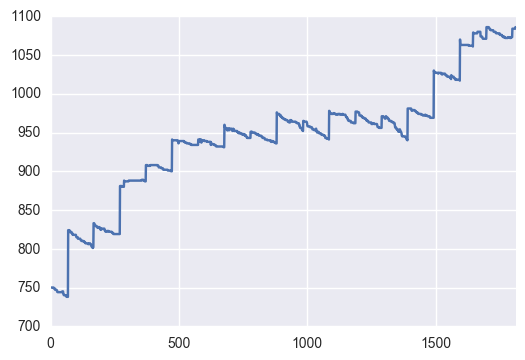

In [33]:
sns.tsplot(data = df.groupby('timestamp').count()['y'])

In [8]:
transformable_fea = [i for i in feature_cols if i not in non_transformable_fea]
df_transformed_shuffled = df_shuffled[transformable_fea].apply(lambda x:1/x, axis=1)
df_transformed_shuffled[non_transformable_fea]=df_shuffled[non_transformable_fea]
df_transformed_shuffled[non_transformable_fea]=df_shuffled[non_transformable_fea]
df_transformed_shuffled[['id','timestamp','y']] = df_shuffled[['id','timestamp','y']]
del(df_shuffled)

In [14]:
from sklearn.preprocessing import Imputer
impute_method = Imputer(strategy='median', axis=0)
X_anomaly_det = impute_method.fit_transform(df_transformed_shuffled[feature_cols])

In [20]:
anomaly_pred = clf.predict(X_anomaly_det)
pd.DataFrame({'anomaly':anomaly_pred,'y':df_transformed_shuffled['y']})

anomaly         y
0              1  0.005177
1              1  0.003340
2             -1  0.016485
3             -1  0.003132
4              1 -0.012504
5              1  0.019126
6              1 -0.007372
7              1 -0.007117
8              1  0.017135
9              1 -0.009127
10             1  0.000722
11             1 -0.000128
12             1  0.004155
13             1 -0.005230
14             1  0.019951
15            -1 -0.005214
16             1 -0.006472
17             1  0.001479
18            -1  0.013030
19             1 -0.023941
20             1  0.003571
21             1  0.004601
22             1 -0.001971
23             1  0.003170
24            -1  0.042299
25             1  0.003117
26             1 -0.045493
27             1 -0.001455
28             1 -0.046988
29             1  0.007469
...          ...       ...
1710726       -1 -0.018511
1710727        1  0.003126
1710728        1  0.018009
1710729        1 -0.010322
1710730       -1  0.003028
1710731        1  0.002399
1710732        1 -0.011794
1710733        1  0.006494
1710734        1  0.028969
1710735       -1  0.002586
1710736        1  0.004212
1710737        1 -0.049289
1710738        1  0.029825
1710739        1  0.012337
1710740        1 -0.007148
1710741        1 -0.025556
1710742        1  0.007068
1710743        1  0.002838
1710744        1 -0.004834
1710745        1 -0.005632
1710746        1 -0.003094
1710747        1 -0.021833
1710748        1 -0.015229
1710749        1 -0.008136
1710750        1  0.002210
1710751       -1  0.018427
1710752        1 -0.006867
1710753       -1  0.021733
1710754        1  0.001098
1710755        1  0.009178

[1710756 rows x 2 columns]

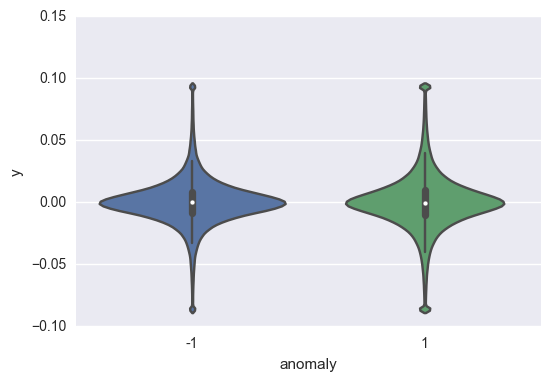

In [27]:
sns.violinplot(x="anomaly", y="y", data=pd.DataFrame({'anomaly':anomaly_pred,'y':df_transformed_shuffled['y']}))

### stats exploration

In [35]:
columns_to_see = df.columns[2:]
dict_stats = dict()
dict_stats['mean'] = list(map(lambda x: df[x].mean(),columns_to_see))
dict_stats['std'] = list(map(lambda x: df[x].std(),columns_to_see))
dict_stats['max'] = list(map(lambda x: df[x].max(),columns_to_see))
dict_stats['min'] = list(map(lambda x: df[x].min(),columns_to_see))
stats_pd = pd.DataFrame.from_dict(dict_stats).set_index(columns_to_see)

In [36]:
derived_cnt=0
fundamental_cnt=0
technical_cnt=0

for i in stats_pd.index:
    if 'derived' in i:
        derived_cnt +=1
    if 'fundamental' in i:
        fundamental_cnt +=1
    if 'technical' in i:
        technical_cnt +=1
print('derived_cnt:%d'%derived_cnt)
print('fundamental_cnt:%d'%fundamental_cnt)
print('technical_cnt:%d'%technical_cnt)

derived_cnt:5
fundamental_cnt:51
technical_cnt:40


In [37]:
derived_cnt_nor=0
fundamental_cnt_nor=0
technical_cnt_nor=0

for i in stats_pd[stats_pd['std']<=3].index:
    if 'derived' in i:
        derived_cnt_nor +=1
    if 'fundamental' in i:
        fundamental_cnt_nor +=1
    if 'technical' in i:
        technical_cnt_nor +=1
print('%d out of %d normalized-able(std<=3) in derived'%(derived_cnt_nor,derived_cnt))
print('%d out of %d normalized-able in fundamental'%(fundamental_cnt_nor,fundamental_cnt))
print('%d out of %d normalized-able in technical'%(technical_cnt_nor,technical_cnt))

0 out of 5 normalized-able(std<=3) in derived
18 out of 51 normalized-able in fundamental
40 out of 40 normalized-able in technical


C:\Users\Miya\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':
C:\Users\Miya\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j
C:\Users\Miya\Anaconda3\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


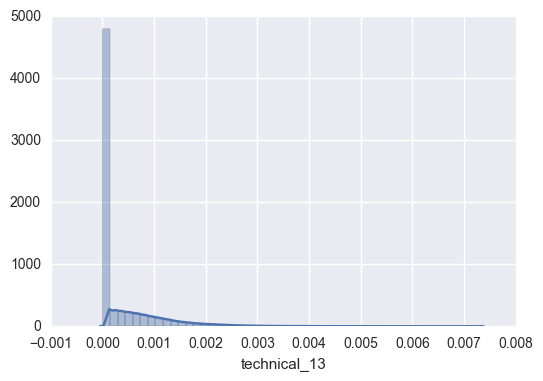

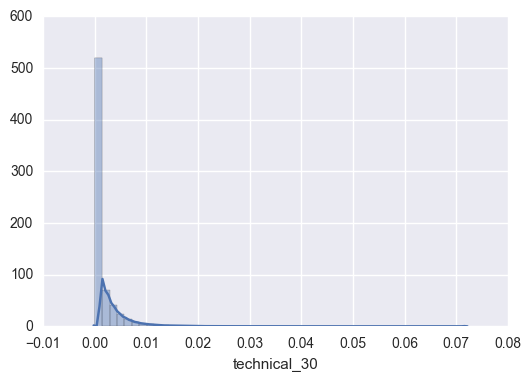

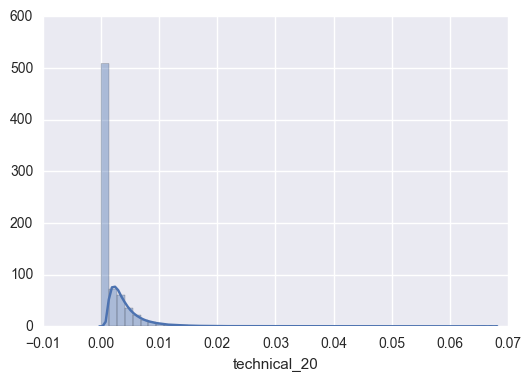

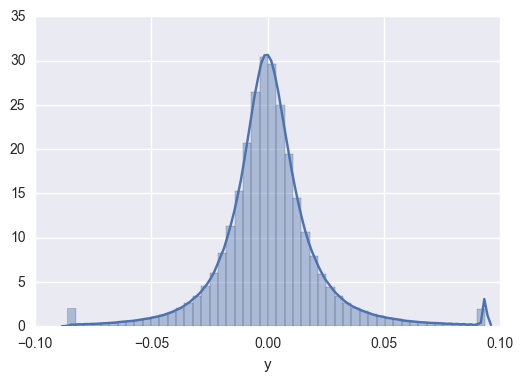

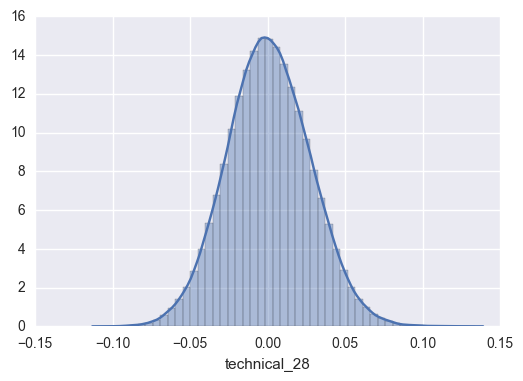

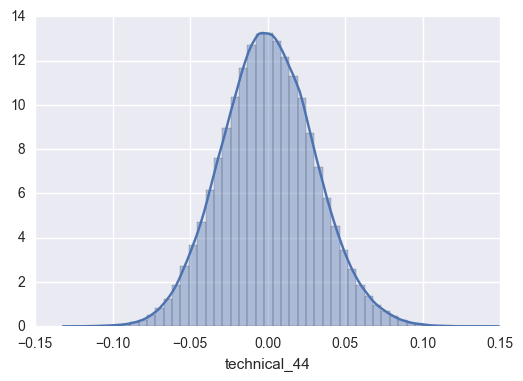

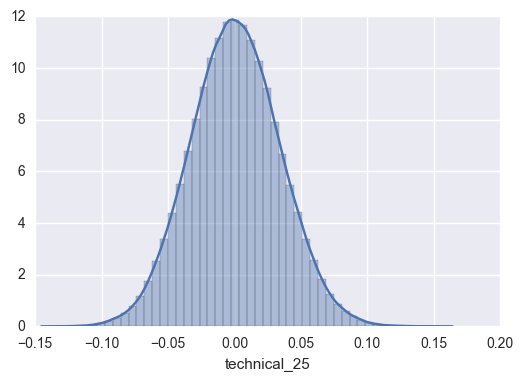

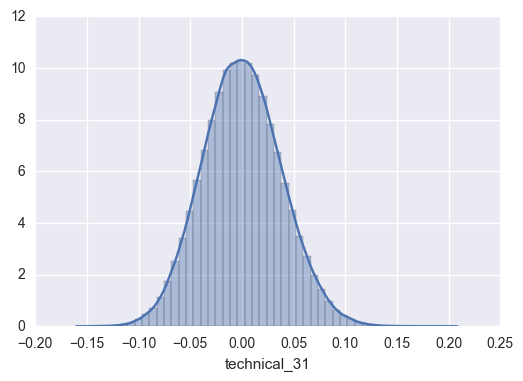

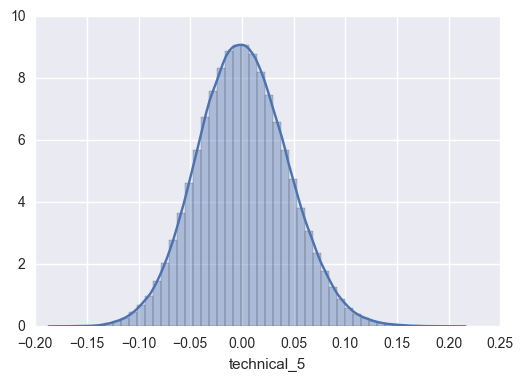

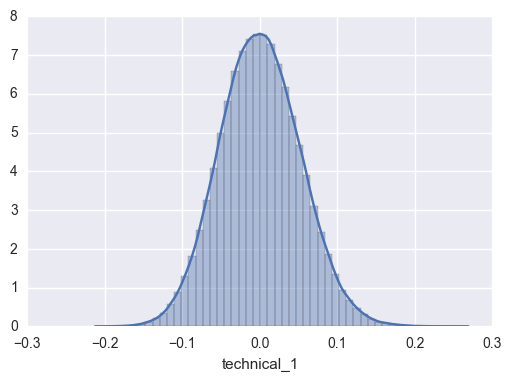

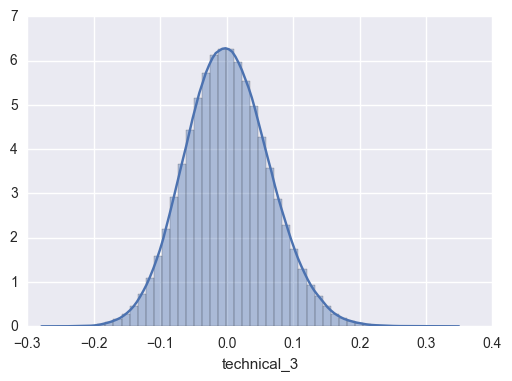

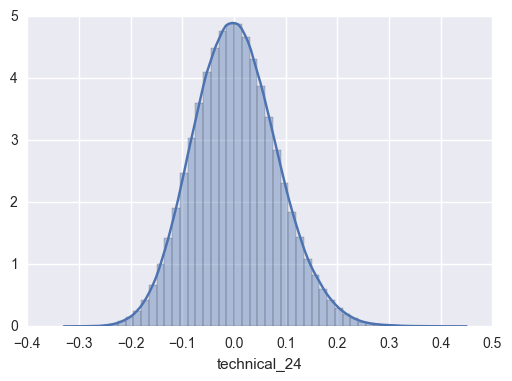

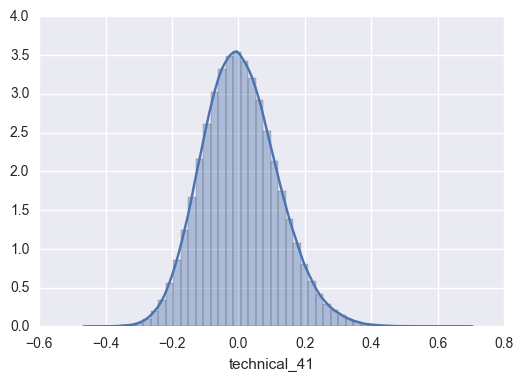

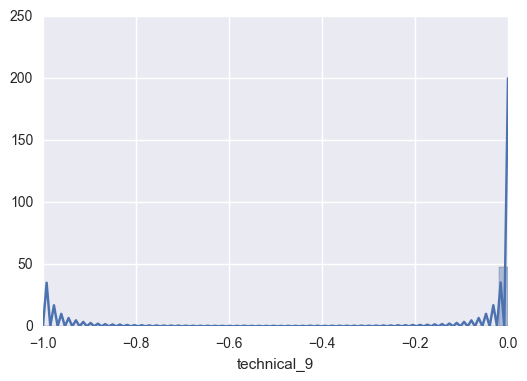

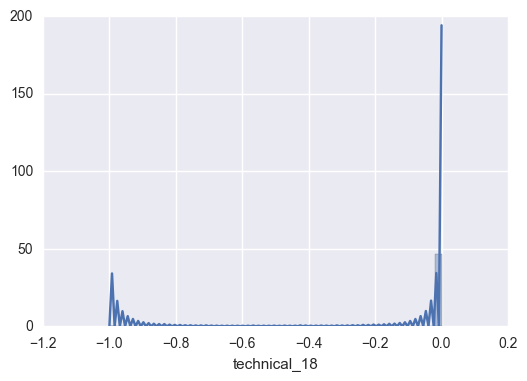

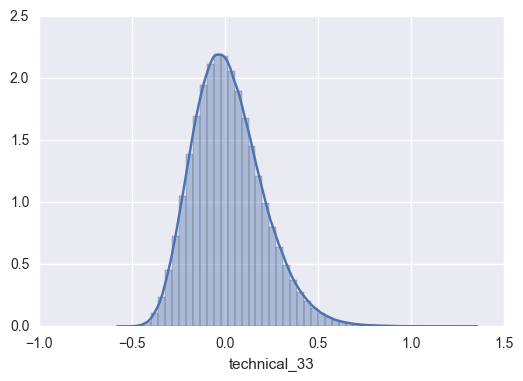

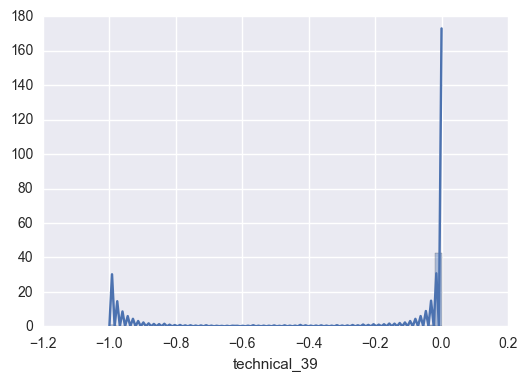

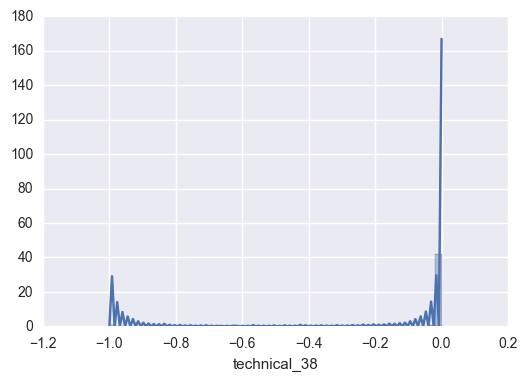

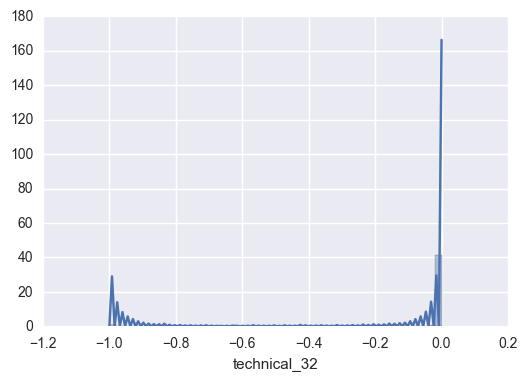

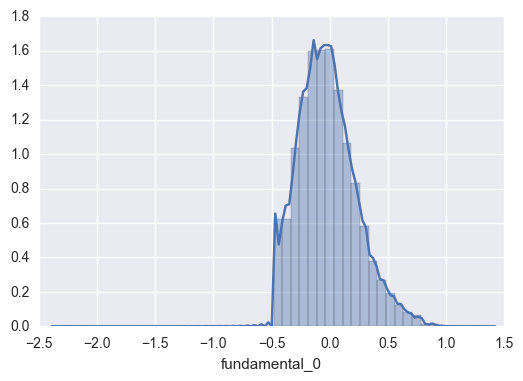

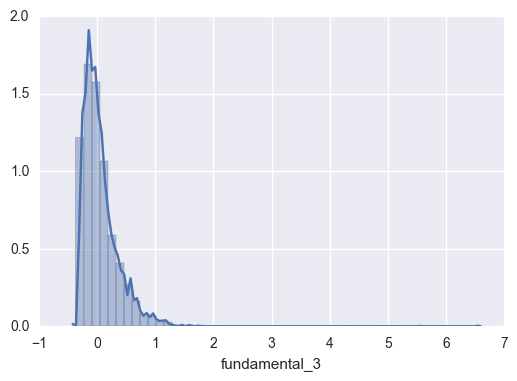

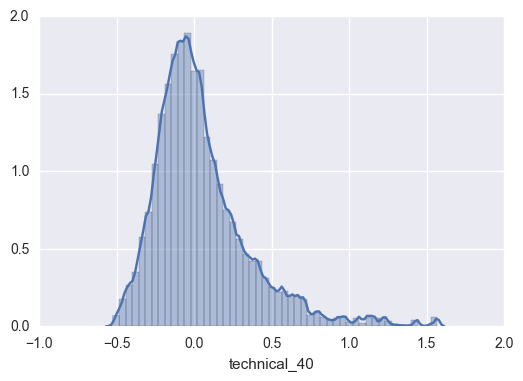

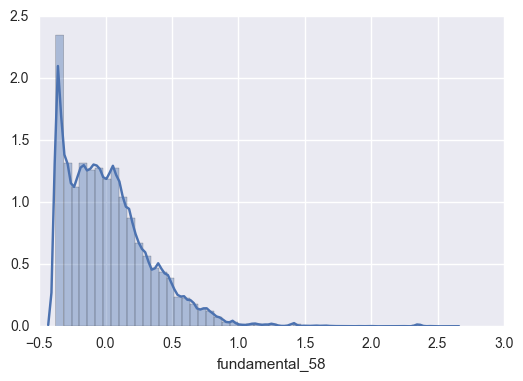

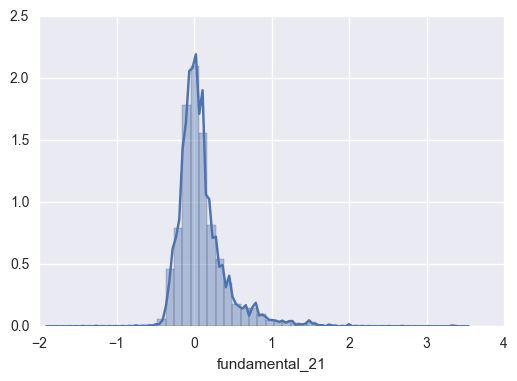

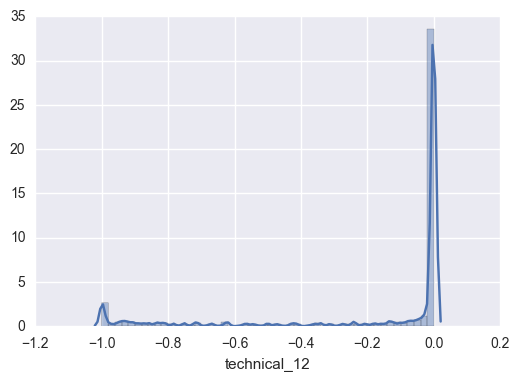

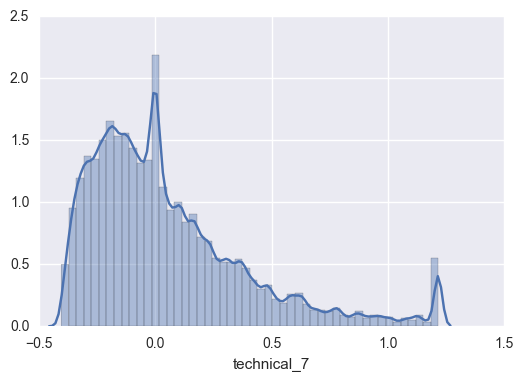

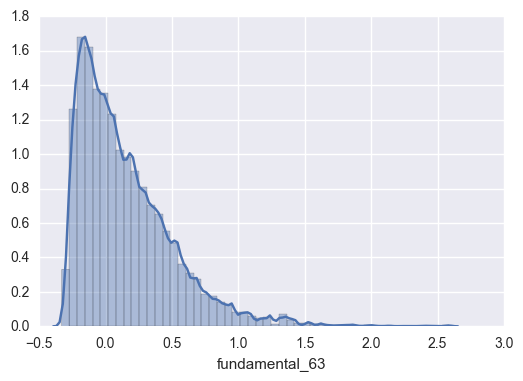

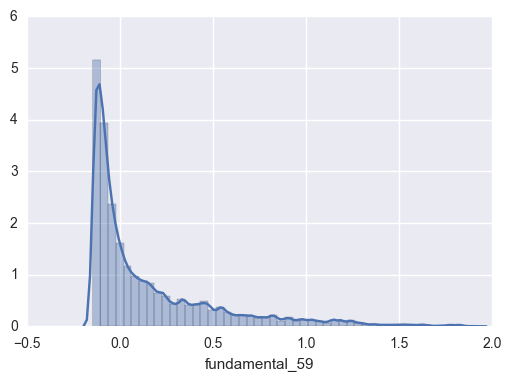

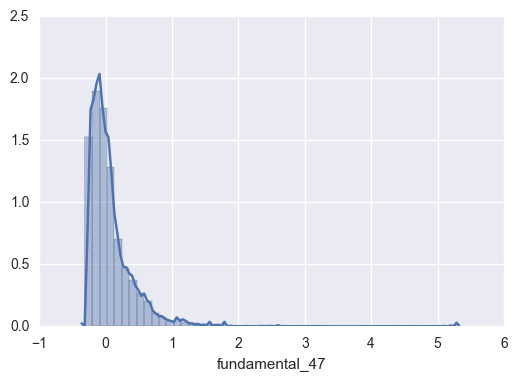

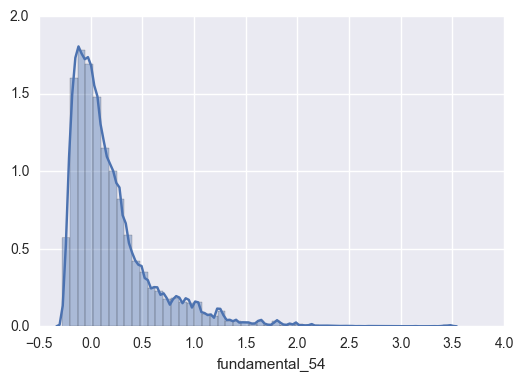

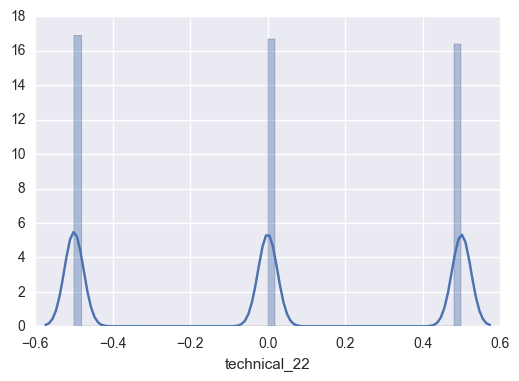

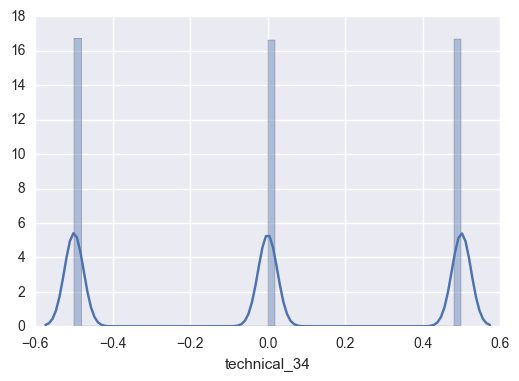

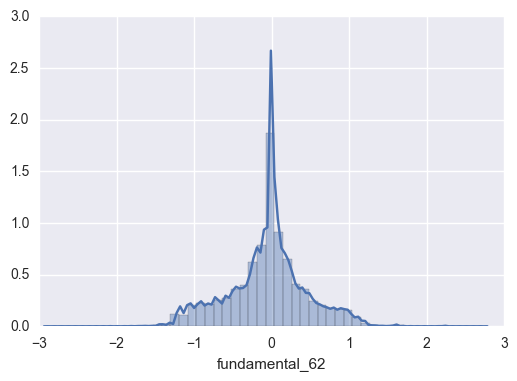

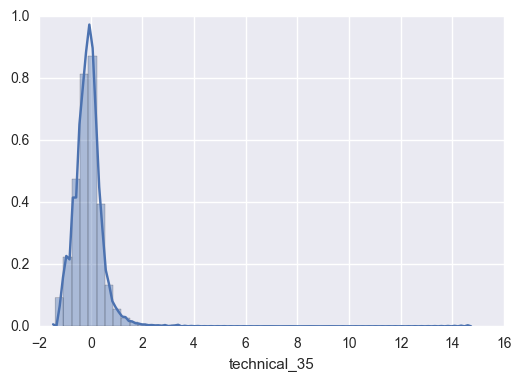

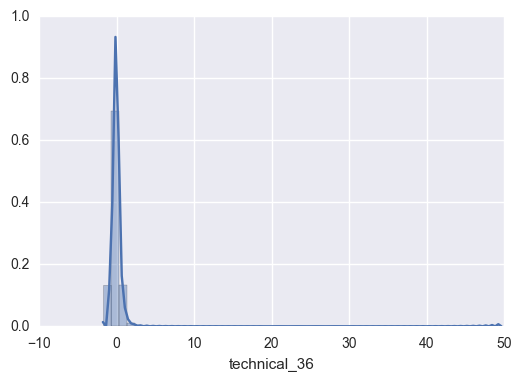

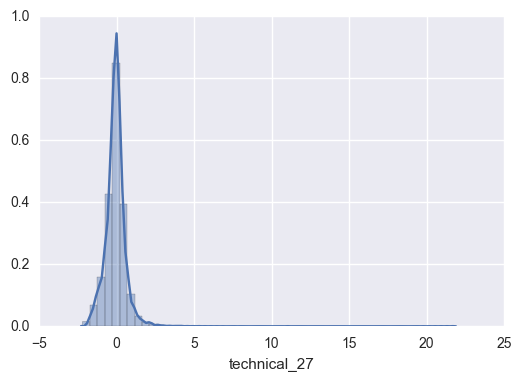

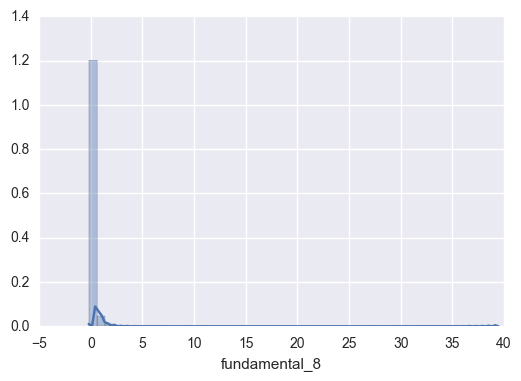

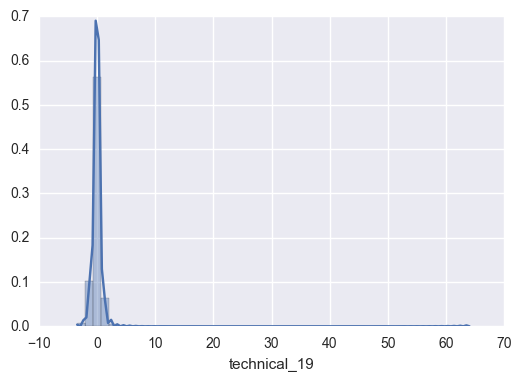

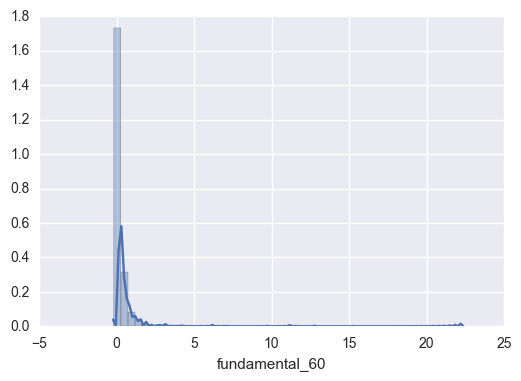

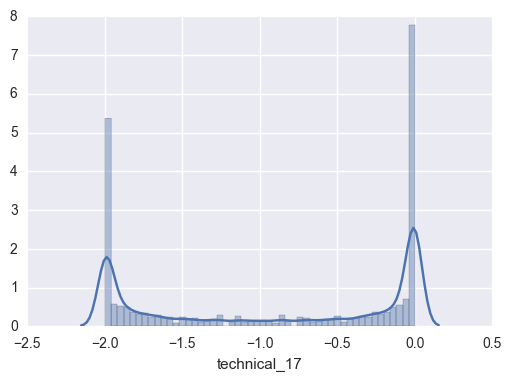

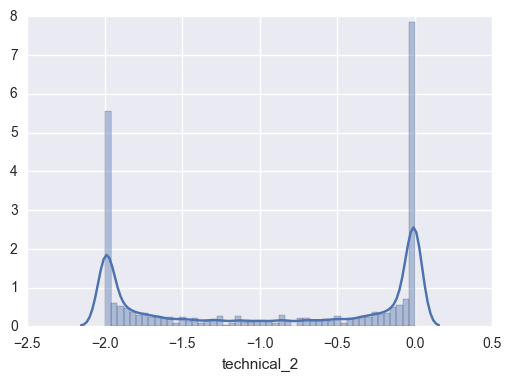

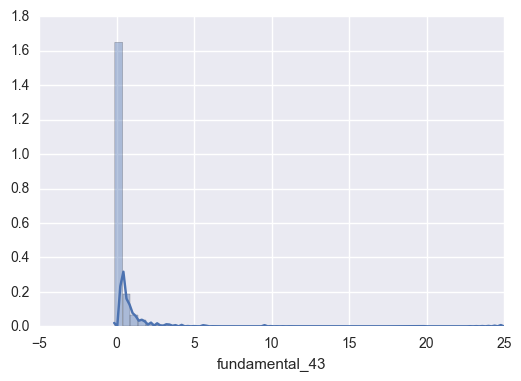

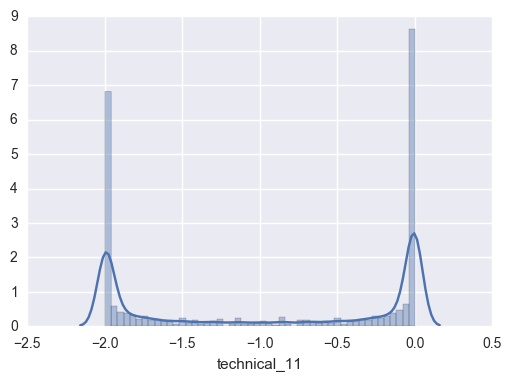

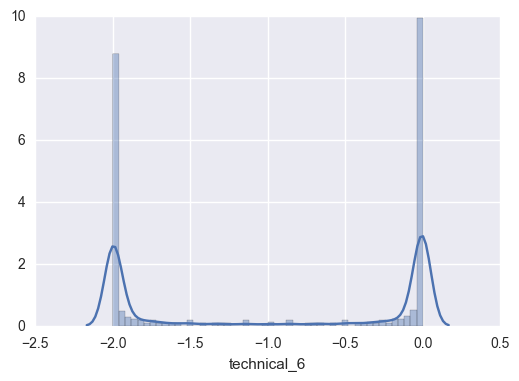

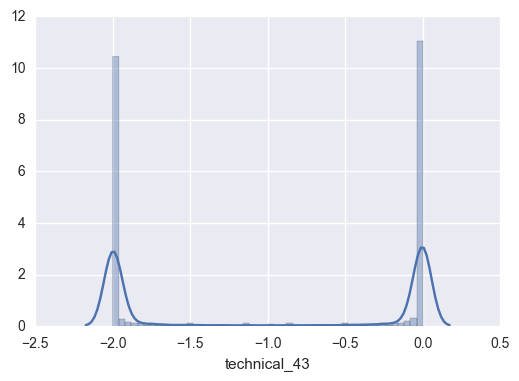

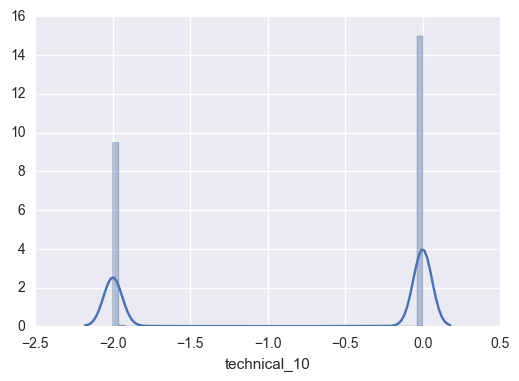

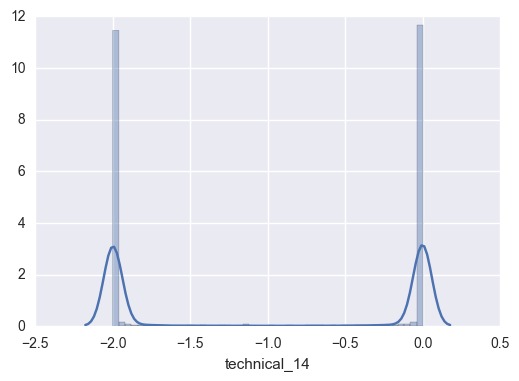

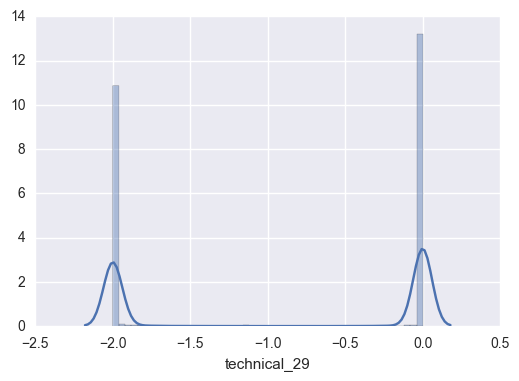

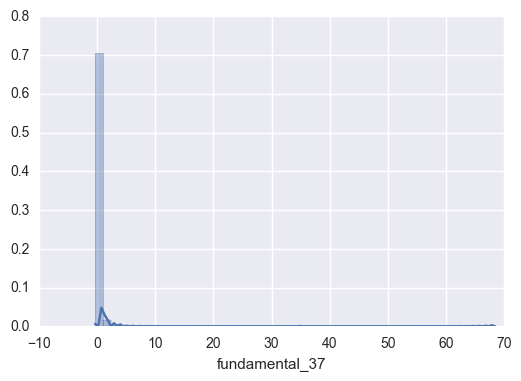

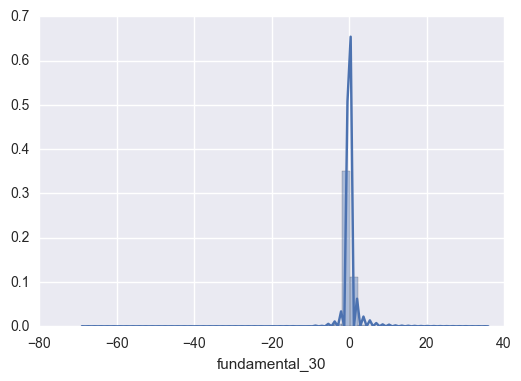

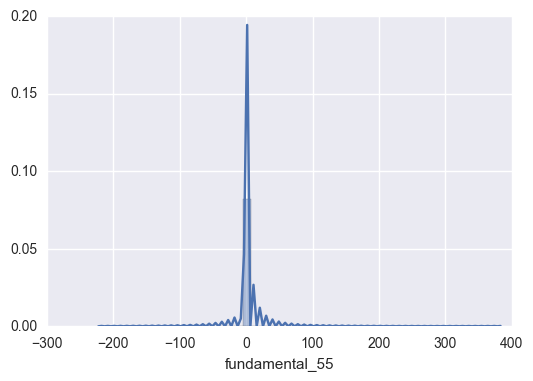

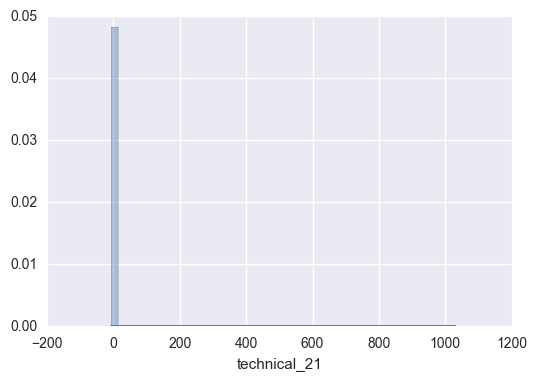

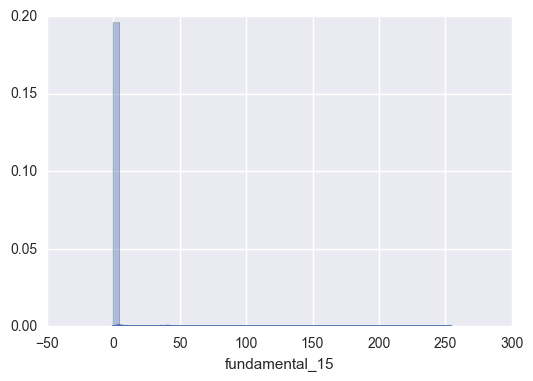

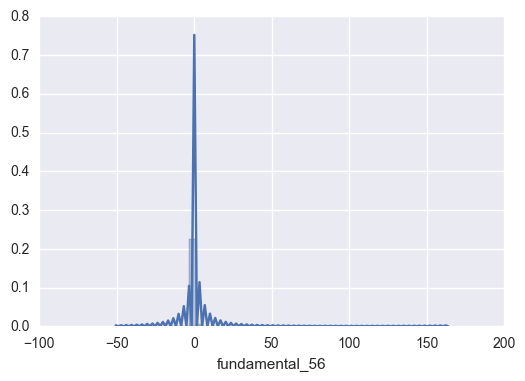

In [39]:
col_nor_already = stats_pd.sort_values(by = 'std')[stats_pd['std']<=3].index
for i in col_nor_already:
    plt.figure()
    sns.distplot(df[i].dropna())